<a href="https://colab.research.google.com/github/tentenNT/6s_polarization/blob/master/image_add.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ロボットビジョン第3回補助教材

０）下準備  
１）画像の入出力  
２）画像のデータ構造  
３）色空間と色変換  
４）色調補正

In [0]:
from google.colab import drive
drive.mount('/content/drive/')
%ls "drive/My Drive/ColabNotebooks/image_add"
%cd "drive/My Drive/ColabNotebooks/image_add"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
data/  image_add.ipynb  out/
/content/drive/My Drive/ColabNotebooks/image_add


-----
## 0）下準備（パッケージのインポートと画像の準備）
### 準備と実行
1. ワークスペース（このスクリプトファイルがある場所）の直下に **./data/\[filename\].png** があることを確認
1. スクリプトの実行（Run），この部分は今はまだ理解できていなくてもOK（できればなおよい）

### 結果の確認
1. ワークスペースの直下にリサイズされた画像 **./data/\[filename\]_resized.png** があること
1. ワークスペース上に出力ファイルの保存用ディレクトリ **./out** が作成されていること

In [0]:
# 必要なパッケージのインポート
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
# ディレクトリ
dataDir = "./data" # 入力データのディレクトリ
outDir  = "./out"  # 出力データのディレクトリ

# 出力ディレクトリがあるかを確認，なければ作成
if not os.path.exists(outDir):
    os.mkdir(outDir)

# ファイル名
#=======================================
originalInputFileName     = "50mm_rho.avi" # <-- ここを自分で用意した画像に変えること
#=======================================
originalInputFileBaseName, originalInputFileExt = os.path.splitext(originalInputFileName)
resizedInputFileName  = originalInputFileBaseName + '_resized' + originalInputFileExt

# 画像のフルパスの設定（要 os パッケージ）
originalInputFilePath = os.path.join(dataDir, originalInputFileName)
resizedInputFilePath  = os.path.join(outDir, resizedInputFileName)

# 各種パラメータ
#=======================================
resizedWidth = 512 # リサイズ後の画像の幅 [px]
FRAMES = 21
ENTIRE_FRAMES = FRAMES * 2
MEANS = 3
ROW = 1024
COL = 1224
#=======================================



In [0]:
def f_to_uint(img):
  img = np.fix(bg_added)
  img = img.astype('uint8')
  return img

In [0]:
def imshow_colab(img, color = None, size = None): 
  figsize = (1024 // 16, 1224 // 16)
  if(size == "full"):
    figsize = (1024 // 8, 1224 // 8)
  elif(size == "half"):
    figsize = (1024 // 32, 1224 // 32)
  
  if(color == "binary"):
    limit = 1
    color = "gray"
  else:
    limit = 255

  img = np.fix(img)
  img = img.astype('uint8')
  fig = plt.figure(figsize = figsize, dpi = 8)
  plt.imshow(img, cmap=color, interpolation='none', vmin = 0, vmax = limit)
  plt.show()

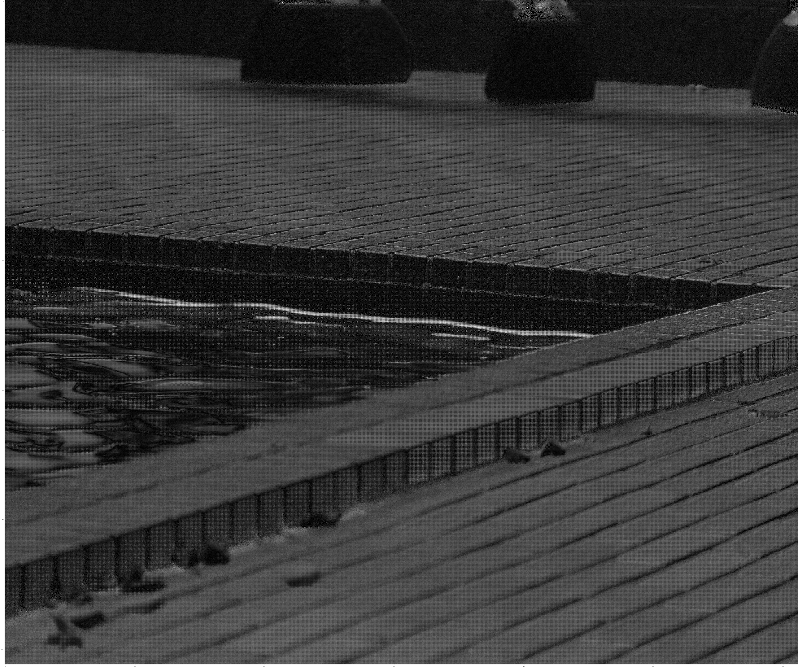

In [0]:
cap = cv2.VideoCapture(originalInputFilePath)
ret, frame = cap.read()
imshow_colab(frame, size="full")
cap.release()

(42, 1024, 1224)


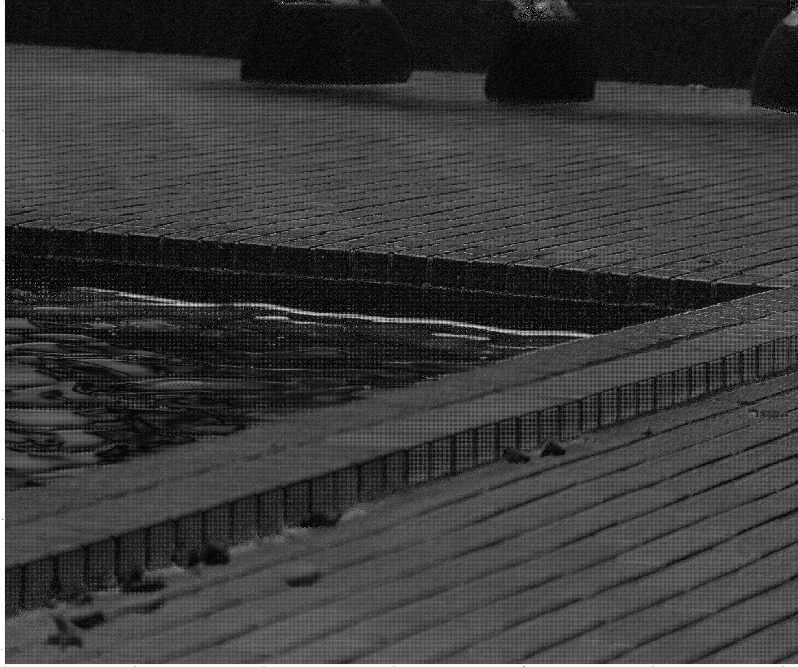

(42, 1024, 1224)


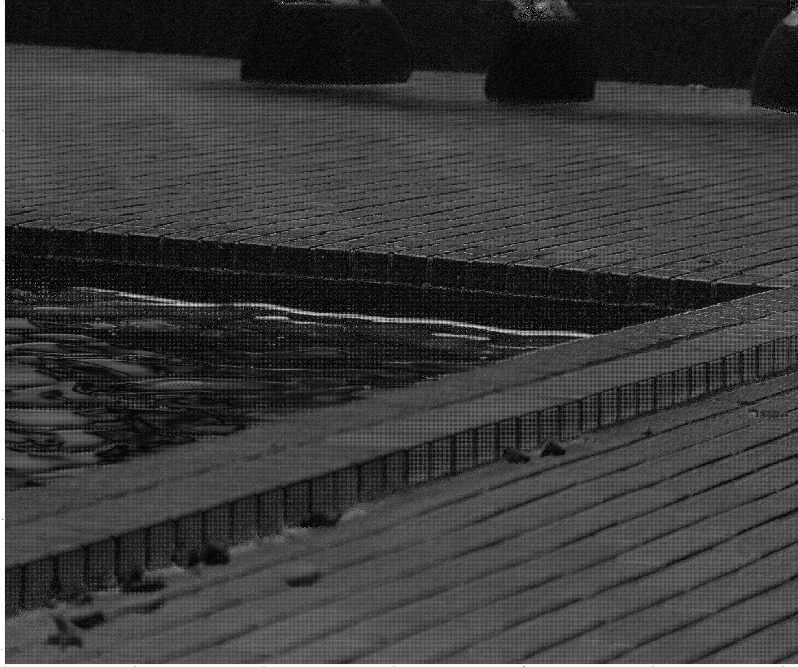

In [0]:
# avi読み込み
def vread(T=30):
    cap = cv2.VideoCapture(originalInputFilePath)
    ret, frame = cap.read()
    row, col, _ = frame.shape
    image_frames = np.array([])
    for i in range(T):
      cap.set(cv2.CAP_PROP_POS_FRAMES, i)
      ret, frame = cap.read()

      if ret:
          frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
          image_frames = np.append(image_frames, frame)
    image_frames =  np.reshape(image_frames, (T, row, col))
    cap.release()
    return image_frames
image_frames = vread(T = ENTIRE_FRAMES)
print(image_frames.shape) # => (例): (21, 600, 600, 3)
imshow_colab(image_frames[0], "gray", "full")

#解像度を揃える
image_frames_resized = np.array([])
if(image_frames.shape[1] > 1024):
  for img in image_frames:
    img	=	cv2.resize(img, None, fx = 0.5, fy = 0.5)
    image_frames_resized = np.append(image_frames_resized, img)
  image_frames = np.zeros((ENTIRE_FRAMES, ROW, COL))
  image_frames += np.reshape(image_frames_resized, (ENTIRE_FRAMES, ROW, COL))

print(image_frames.shape)
imshow_colab(image_frames[0], "gray", "full")

In [0]:
#解像度変更用
def resize_images(image_frames, mag):
  image_frames_resized = np.array([])
  for img in image_frames:
    img	=	cv2.resize(img, None, fx = mag, fy = mag)
    image_frames_resized = np.append(image_frames_resized, img)
  image_frames = np.zeros((ENTIRE_FRAMES, ROW*mag, COL*mag))
  image_frames += np.reshape(image_frames_resized, (ENTIRE_FRAMES, ROW*mag, COL*mag))
  return image_frames

In [0]:
#x = resize_images()

In [0]:
# 画像の平均化
def mean_images(image_frames):
    i = 0
    row, col = image_frames[0].shape
    img_sum = np.zeros((row, col))
    image_frames_means = np.array([])

    for img in image_frames:
      i += 1
      img_sum += img
      if(i % MEANS == 0):
        print(i)
        img_sum /= MEANS
        image_frames_means = np.append(image_frames_means, img_sum)
        img_sum = np.zeros((row, col))
    image_frames_means = np.reshape(image_frames_means, (ENTIRE_FRAMES // MEANS, row, col))

    imshow_colab(image_frames_means[0], "gray", "full")
    return image_frames_means


In [0]:
#一時コメントアウト
#image_frames_means = mean_images(image_frames)

image_frames_means = image_frames
row, col = image_frames[0].shape

In [0]:
#for img in image_frames_means:
#  imshow_colab(img, "gray", "full")

1
bg_added
(array([], dtype=int64), array([], dtype=int64))
0


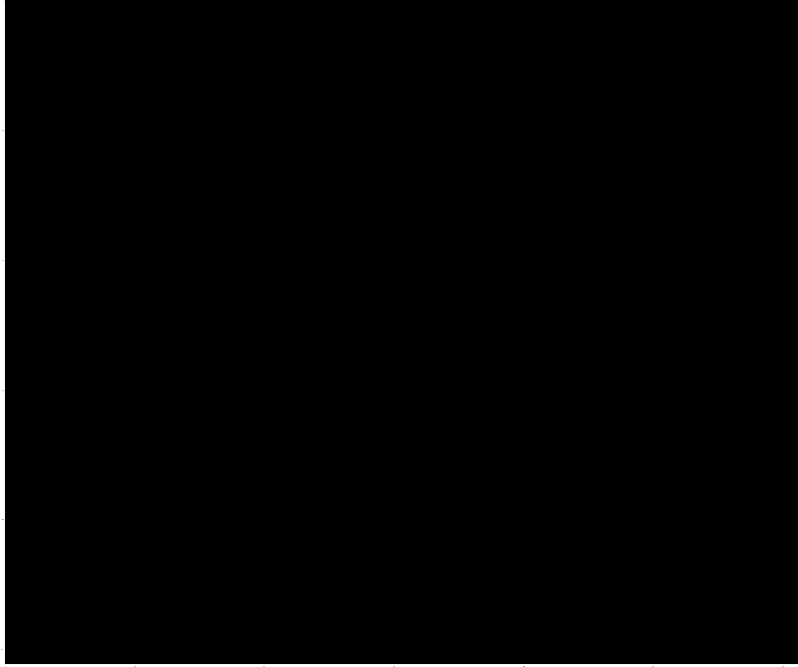

2
bg_added
(array([  0,   1,   1, ..., 923, 931, 941]), array([794, 441, 443, ...,  79,  23,  25]))
255


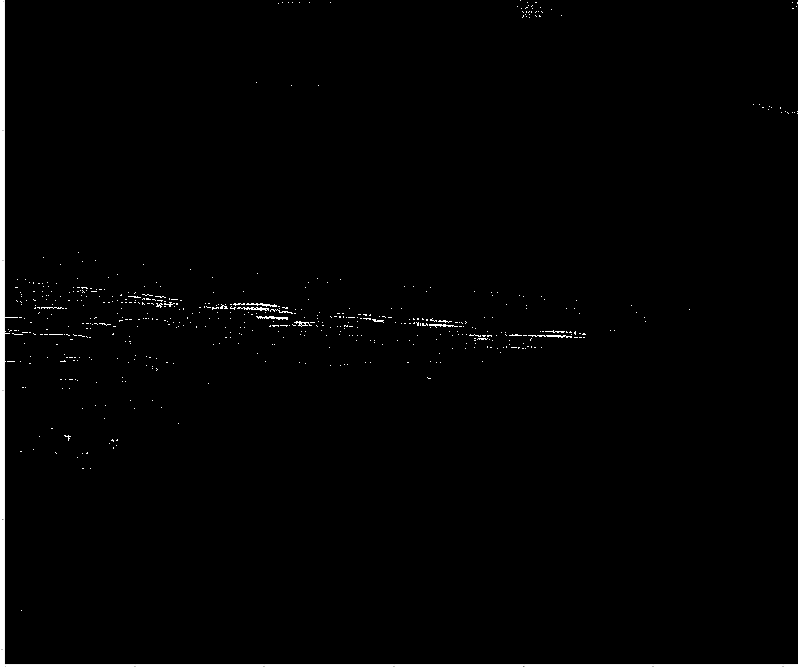

3
bg_added
(array([  0,   0,   0, ..., 925, 943, 945]), array([420, 426, 438, ...,  77,  23,  25]))
0


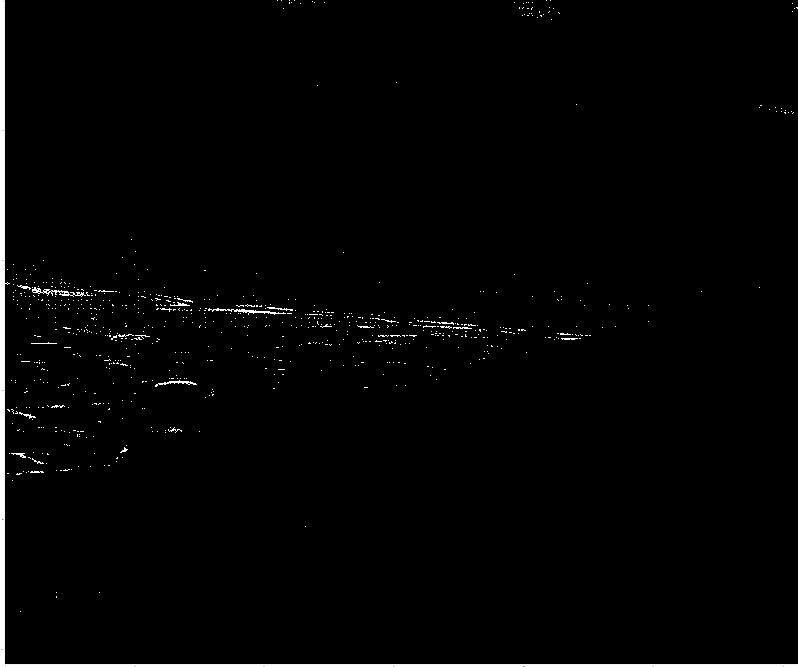

4
bg_added
(array([  0,   0,   0, ..., 945, 951, 951]), array([420, 490, 789, ...,  23,  17,  21]))
0


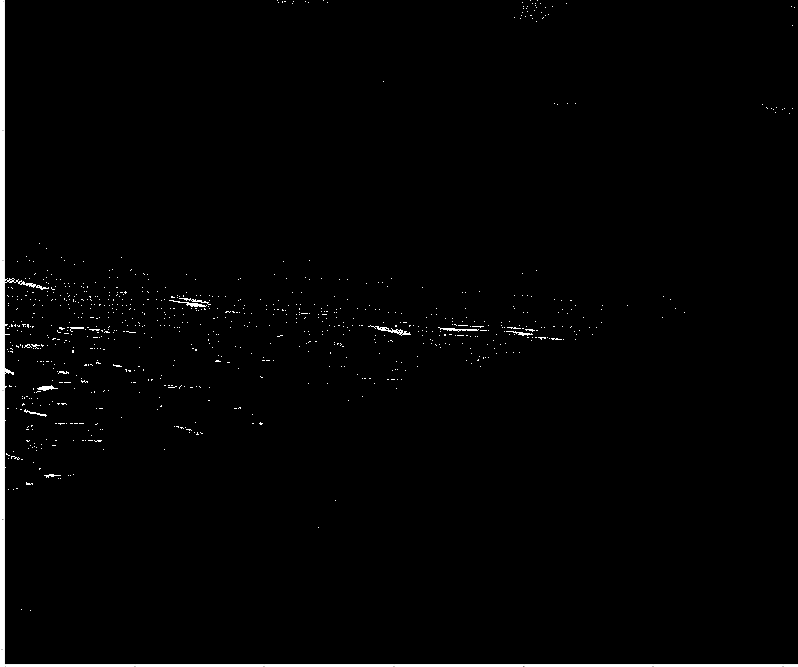

5
bg_added
(array([  0,   0,   0, ..., 939, 941, 943]), array([433, 447, 497, ...,   3,  13,  19]))
0


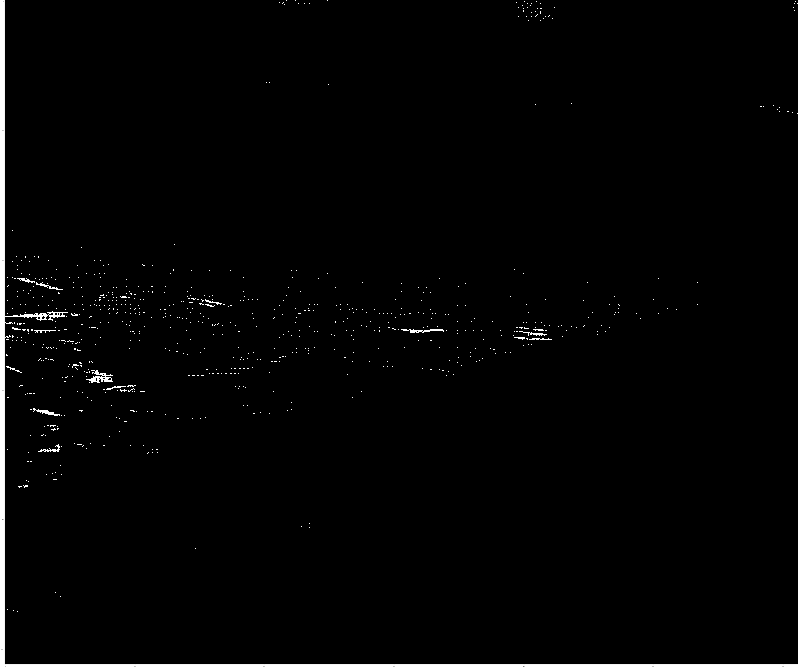

6
bg_added
(array([  0,   0,   0, ..., 933, 947, 959]), array([431, 464, 807, ...,  25,   3,   7]))
0


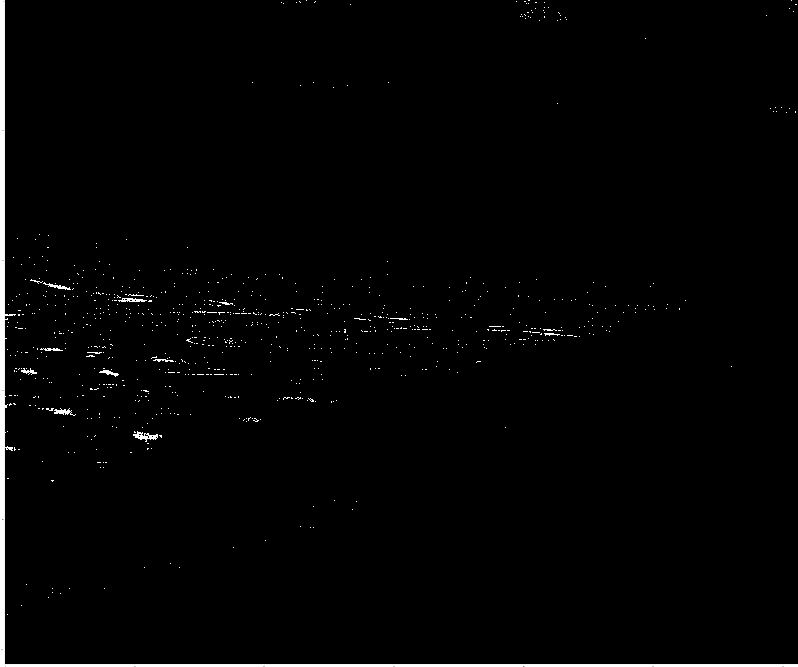

7
bg_added
(array([  0,   0,   0, ..., 935, 939, 955]), array([418, 434, 469, ...,  43,   5,  19]))
0


KeyboardInterrupt: ignored

In [0]:
bg_added = np.zeros((row, col))
#fgbg = cv2.createBackgroundSubtractorMOG2(varThreshold = 25, detectShadows=False)
fgbg = cv2.bgsegm.createBackgroundSubtractorMOG(history = 200, nmixtures = 3, backgroundRatio = 0.95, noiseSigma = 1)
i = 0
for img in image_frames_means:
    i += 1
    img = np.fix(img)
    img = img.astype('uint8')
    print(i)
    print("bg_added")
    imshow_colab(fgmask, "gray", "full")

    #fig = plt.figure()
    #plt.imshow(bg_added, cmap="gray")
    #plt.show()

bg_added = bg_added // image_frames_means.shape[0]
imshow_colab(bg_added, "binary", "full")

* loops = 50
* cv2.bgsegm.createBackgroundSubtractorMOG()
* bg_added = cv2.morphologyEx(bg_added, cv2.MORPH_OPEN, kernel)


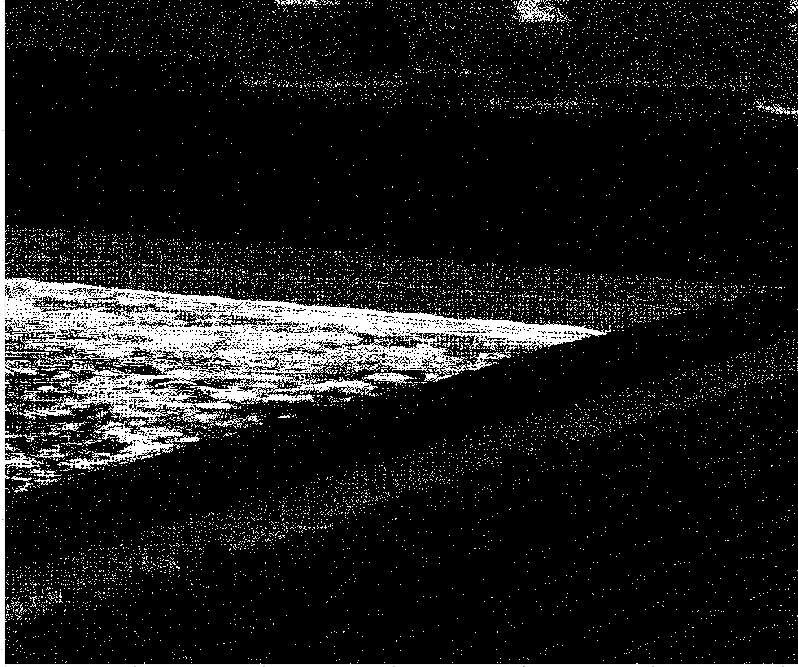

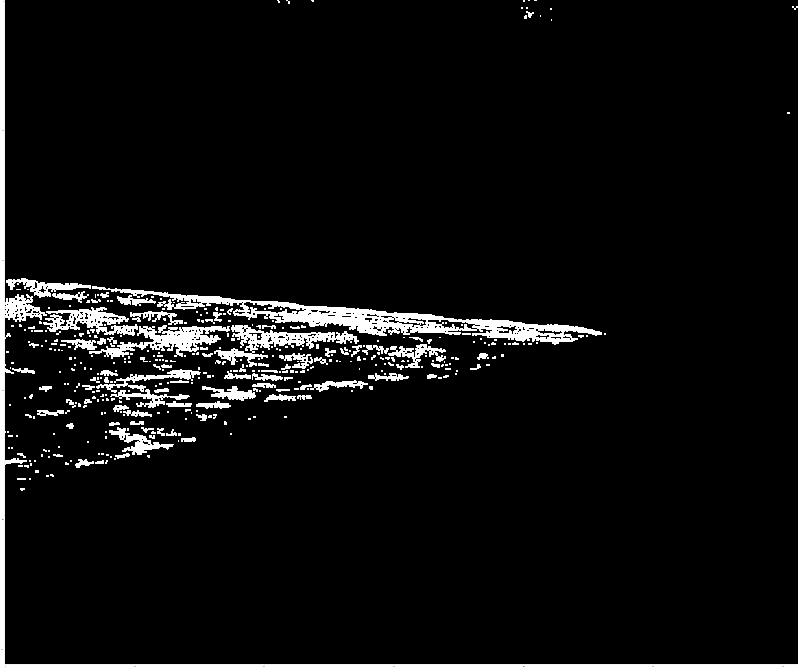

In [0]:
imshow_colab(bg_added, "binary", "full")

kernel = np.ones((3,3),np.uint8)
#bg_added = cv2.dilate(bg_added, kernel, iterations = 1)
#bg_added = cv2.morphologyEx(bg_added, cv2.MORPH_CLOSE, kernel)
# 最初はこいつをやる
bg_added = cv2.morphologyEx(bg_added, cv2.MORPH_OPEN, kernel)

imshow_colab(bg_added, "binary", "full")

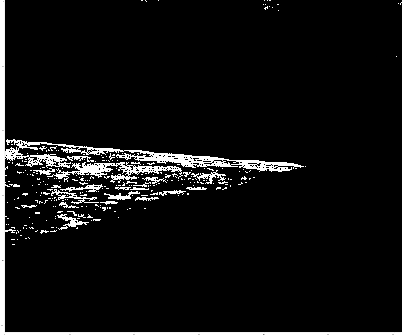

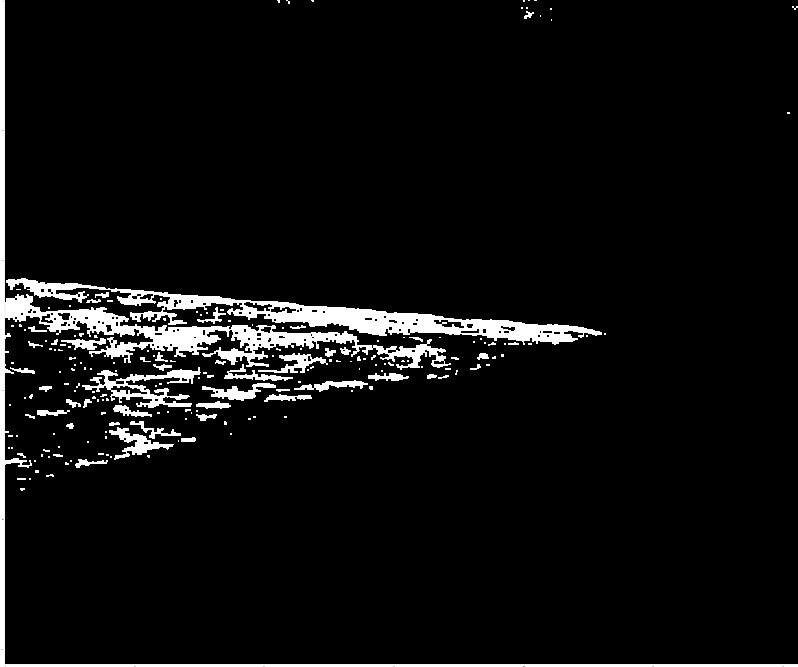

In [0]:
imshow_colab(bg_added, "binary")

kernel = np.ones((3,3),np.uint8)
#bg_added = cv2.dilate(bg_added, kernel, iterations = 1)
# 次はこっち
bg_added = cv2.morphologyEx(bg_added, cv2.MORPH_CLOSE, kernel)
#bg_added = cv2.morphologyEx(bg_added, cv2.MORPH_OPEN, kernel)

imshow_colab(bg_added, "binary", "full")

In [0]:
# 画像を点集合として扱うためにインデックスを取得
point_x_array, point_y_array = np.where(bg_added > 0)
point_array = np.empty((0,2), int)
for x, y in zip(point_x_array, point_y_array):
    point_array = np.append(point_array, np.array([[x, y]]), axis=0)
print(point_array)

# 

[  0   0   0 ... 951 955 959] [418 420 426 ...  21  19   7]
418


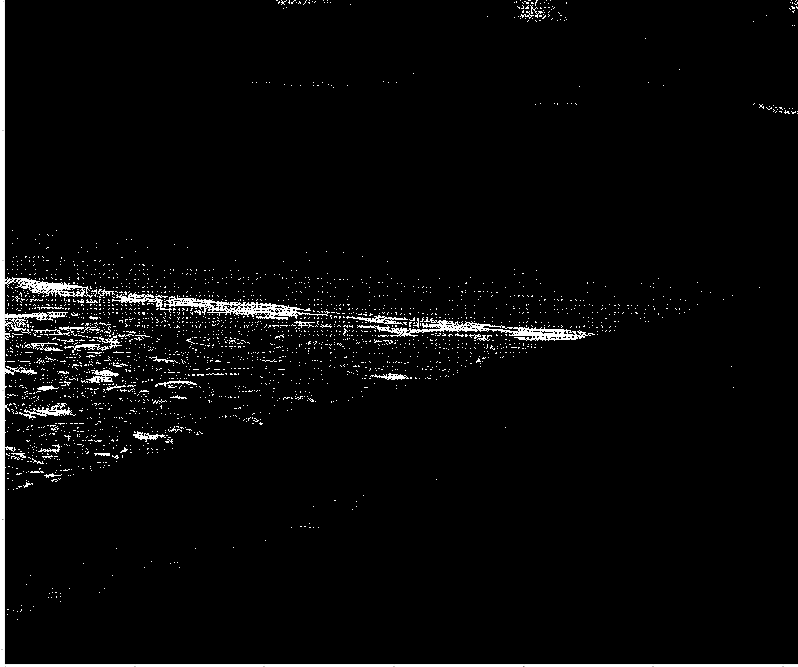

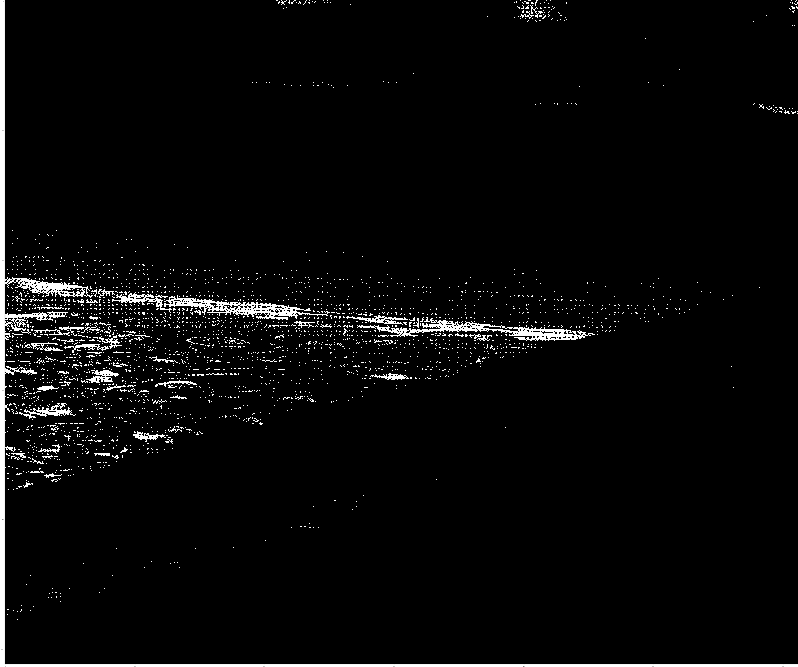

In [0]:
imshow_colab(bg_added, "binary", "full")

kernel = np.ones((3,3),np.uint8)
#  膨張処理
#bg_added = cv2.dilate(bg_added, kernel, iterations = 1)
# bg_added = cv2.morphologyEx(bg_added, cv2.MORPH_CLOSE, kernel)
#bg_added = cv2.morphologyEx(bg_added, cv2.MORPH_OPEN, kernel)

imshow_colab(bg_added, "binary", "full")

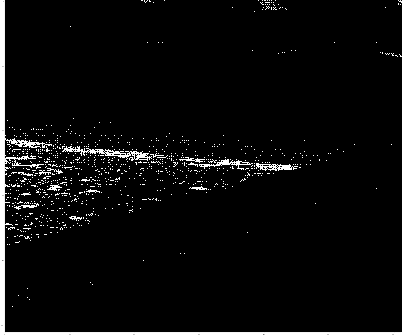

[array([[[  7, 959]]], dtype=int32), array([[[ 19, 955]]], dtype=int32), array([[[ 21, 951]]], dtype=int32), array([[[ 17, 951]]], dtype=int32), array([[[  3, 947]]], dtype=int32), array([[[ 25, 945]]], dtype=int32), array([[[ 23, 945]]], dtype=int32), array([[[ 21, 945]]], dtype=int32), array([[[ 11, 945]]], dtype=int32), array([[[ 23, 943]]], dtype=int32), array([[[ 19, 943]]], dtype=int32), array([[[ 39, 941]]], dtype=int32), array([[[ 25, 941]]], dtype=int32), array([[[ 13, 941]]], dtype=int32), array([[[ 25, 939]]], dtype=int32), array([[[  5, 939]]], dtype=int32), array([[[  3, 939]]], dtype=int32), array([[[ 11, 937]]], dtype=int32), array([[[ 43, 935]]], dtype=int32), array([[[ 29, 935]]], dtype=int32), array([[[  7, 935]]], dtype=int32), array([[[ 25, 933]]], dtype=int32), array([[[ 15, 933]]], dtype=int32), array([[[ 29, 931]]], dtype=int32), array([[[ 23, 931]]], dtype=int32), array([[[  9, 931]]], dtype=int32), array([[[  9, 929]]], dtype=int32), array([[[ 85, 927]]], dtype

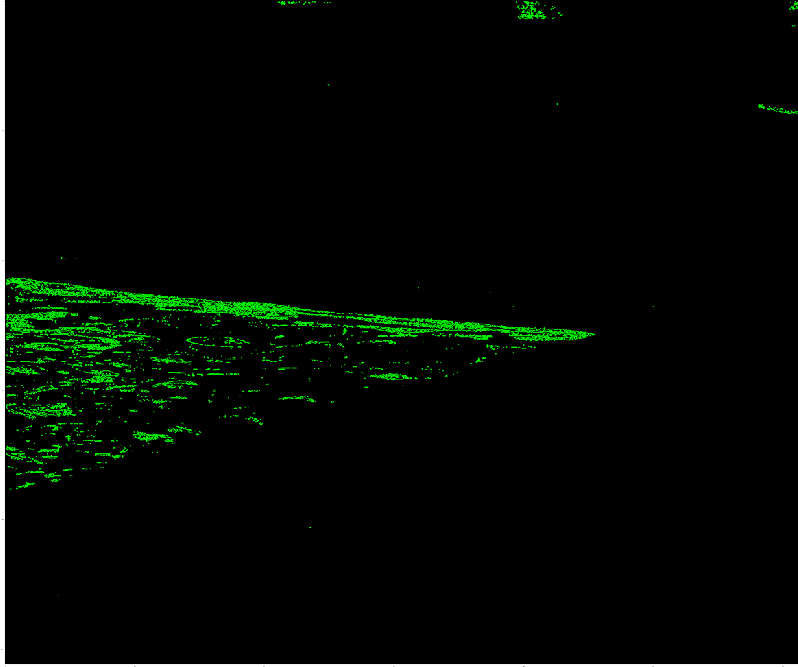

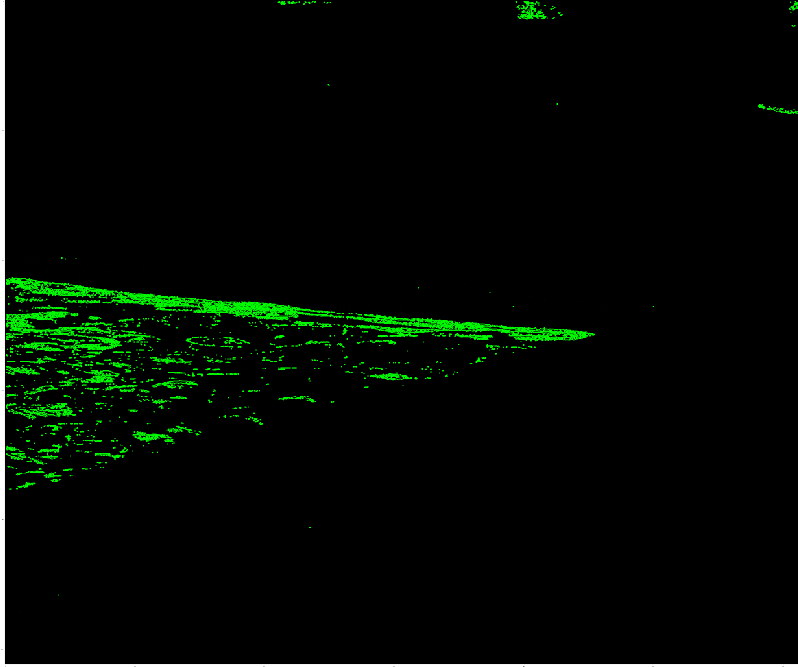

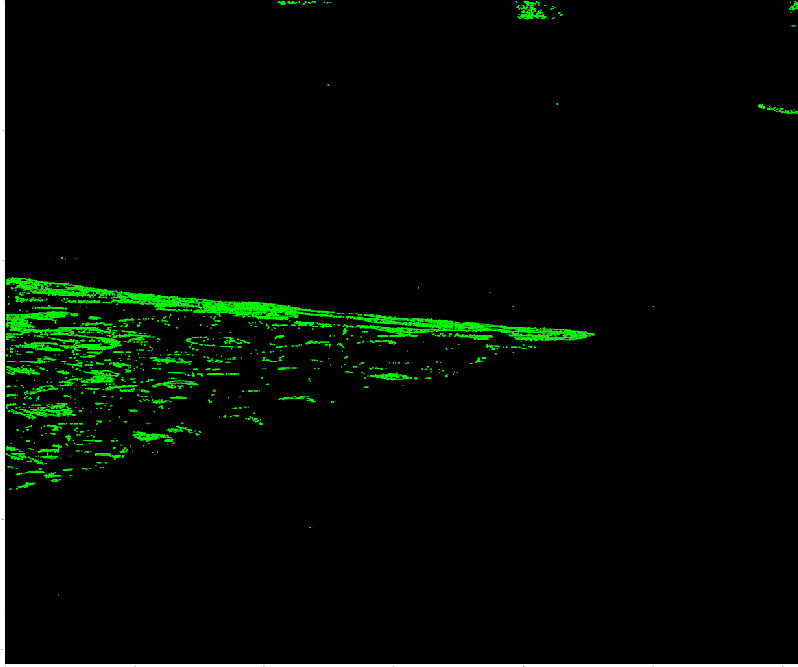

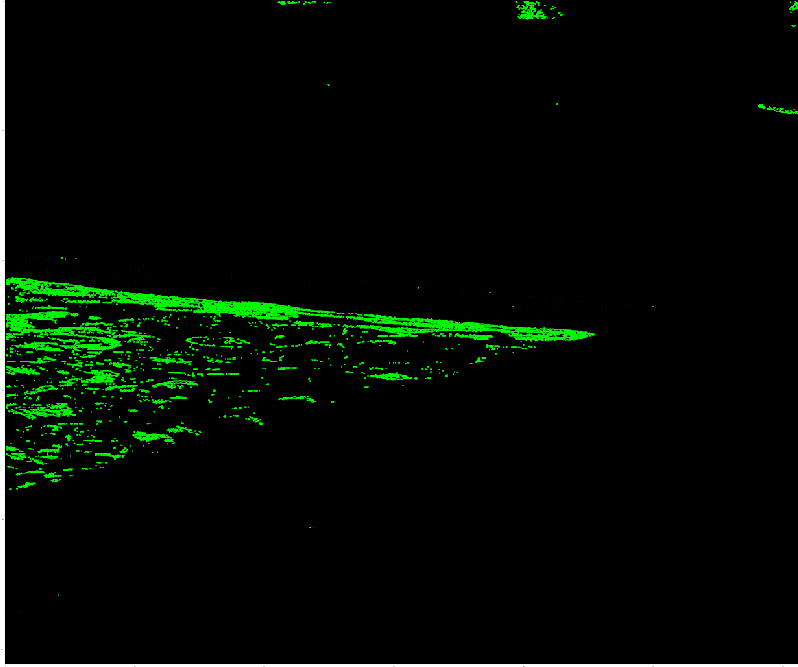

KeyboardInterrupt: ignored

In [0]:
ret,thresh = cv2.threshold(bg_added,1,255,cv2.THRESH_BINARY)
imshow_colab(thresh, "gray")
thresh = f_to_uint(thresh)

# Finding contours for the thresholded image
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# create hull array for convex hull points
hull = []
 
# calculate points for each contour
for i in range(len(contours)):
    # creating convex hull object for each contour
    hull.append(cv2.convexHull(contours[i], False))

# create an empty black image
drawing = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8)
 
# draw contours and hull points
for i in range(len(contours)):
    color_contours = (0, 255, 0) # green - color for contours
    color = (255, 0, 0) # blue - color for convex hull
    # draw ith contour
    imshow_colab(cv2.drawContours(drawing, contours, -1, color_contours, 1, cv2.LINE_AA, hierarchy), size = "full")
    #imshow_colab(cv2.drawContours(drawing, contours, i, color_contours, 1, cv2.LINE_AA, hierarchy), size = "full")
    # draw ith convex hull object
    #imshow_colab(cv2.drawContours(drawing, hull, i, color, 1, 8))

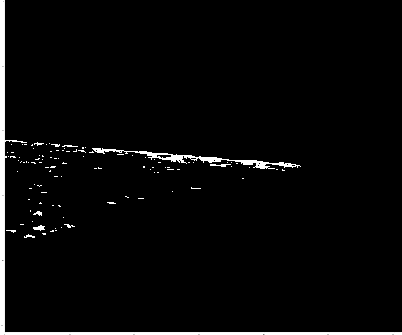

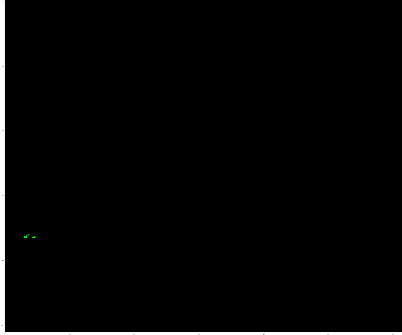

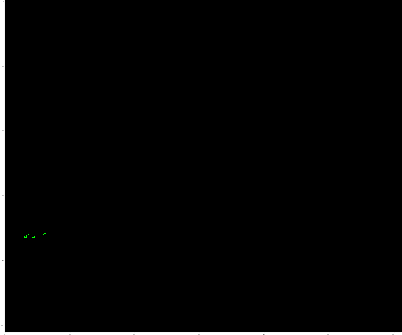

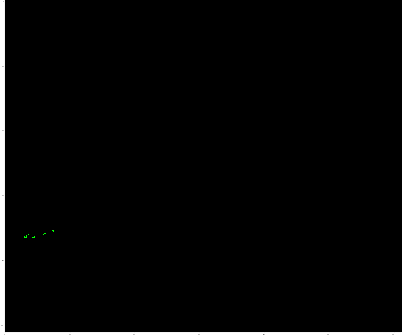

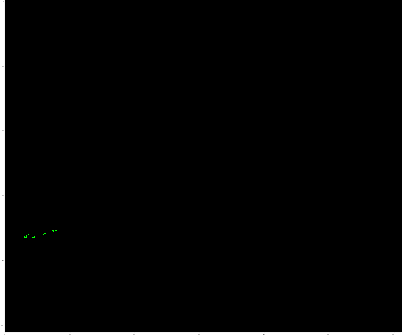

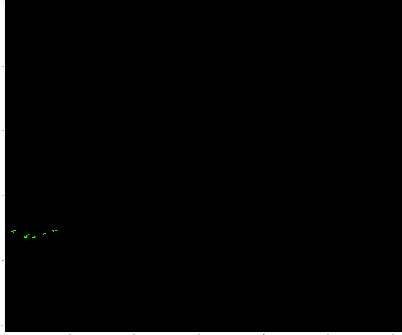

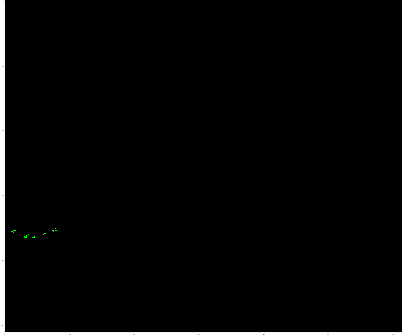

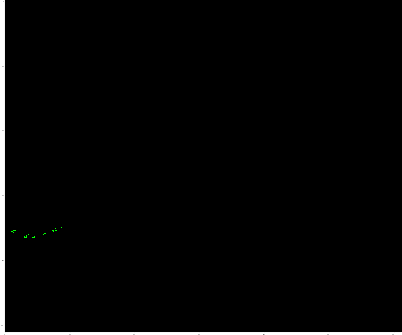

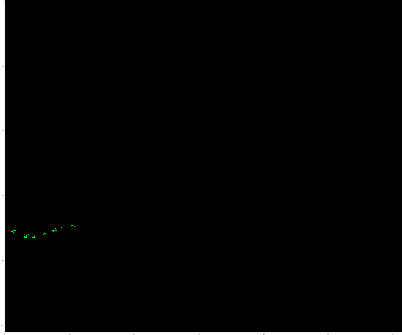

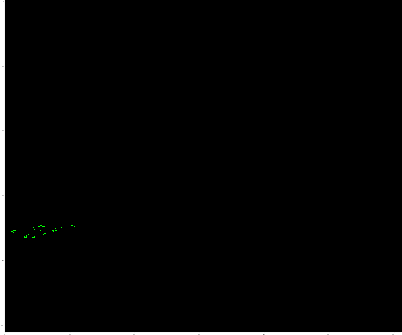

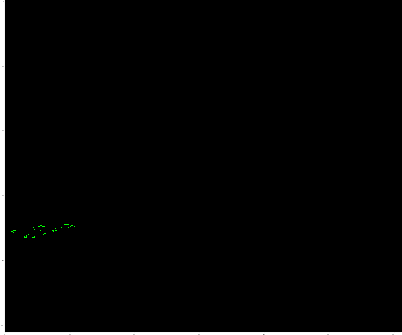

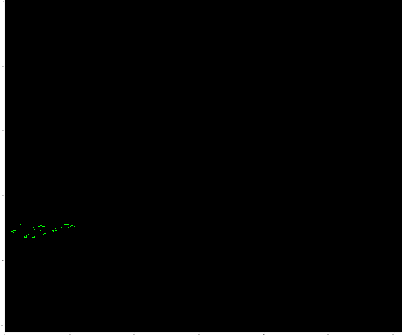

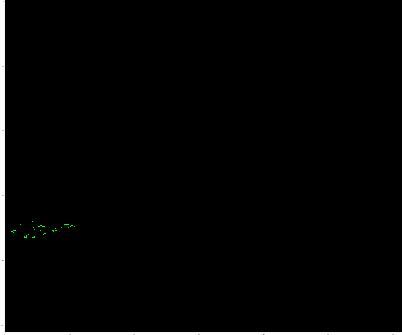

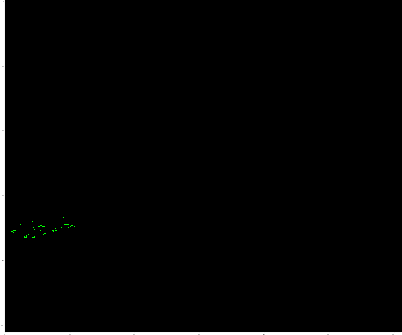

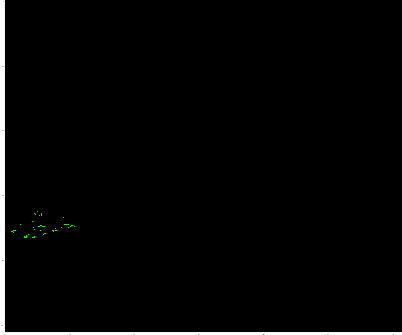

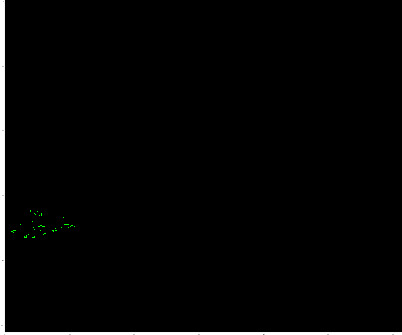

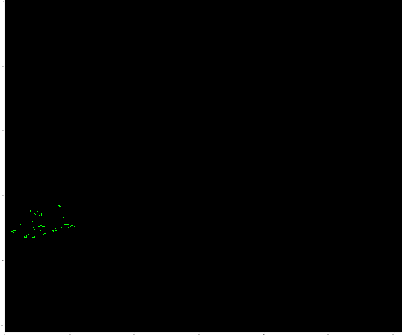

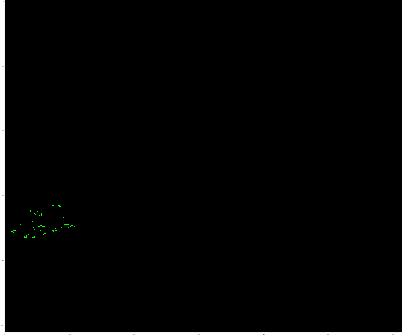

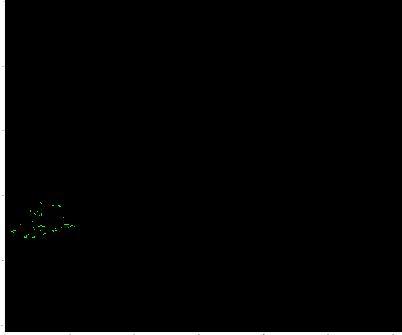

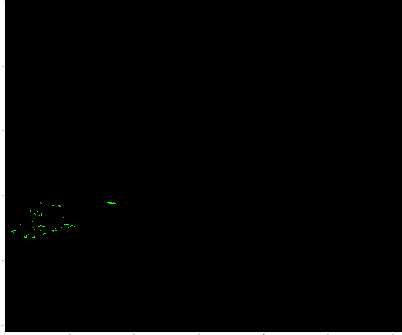

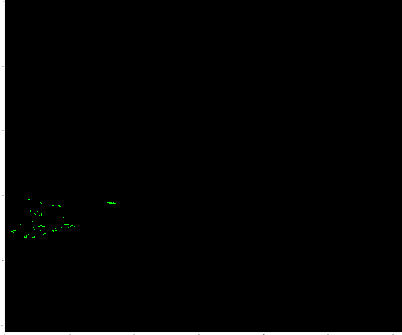

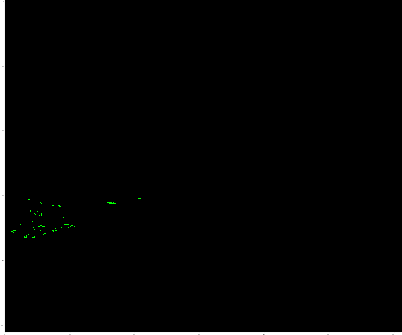

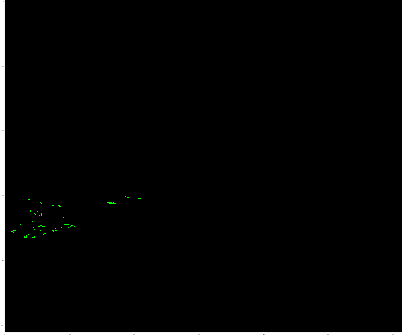

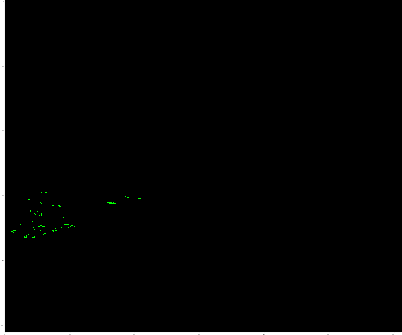

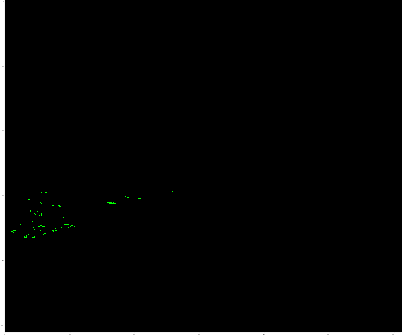

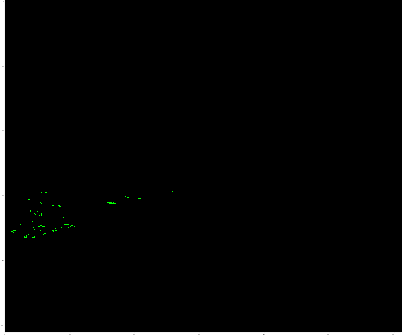

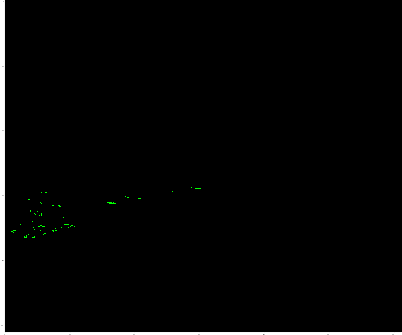

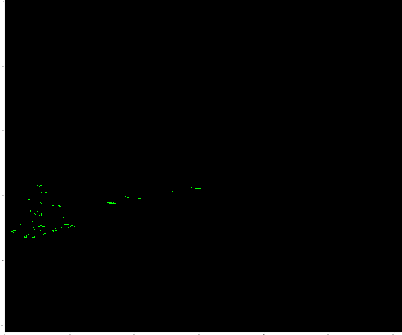

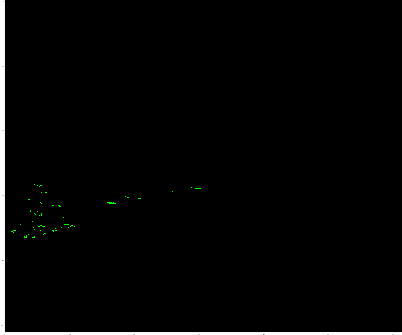

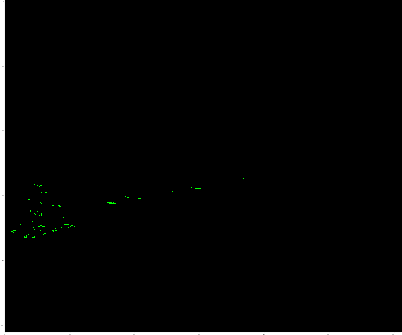

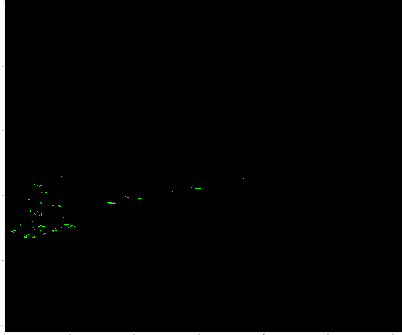

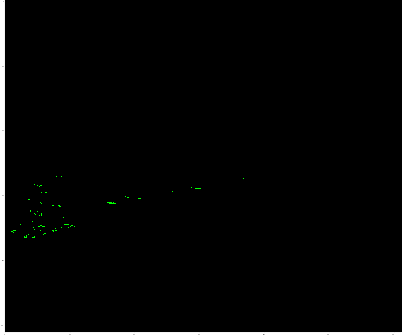

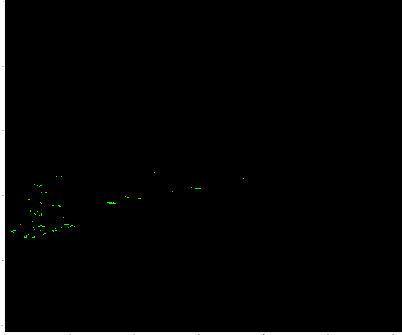

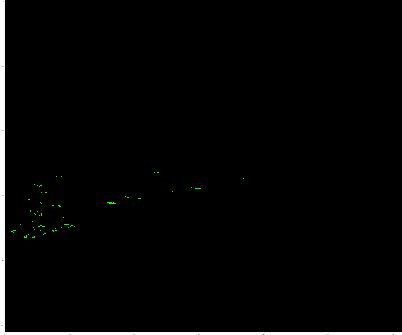

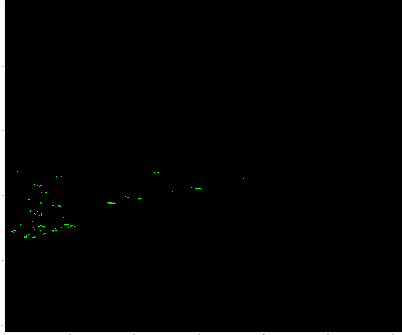

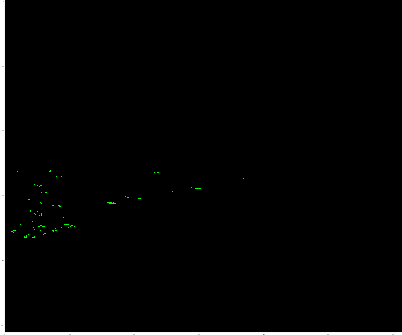

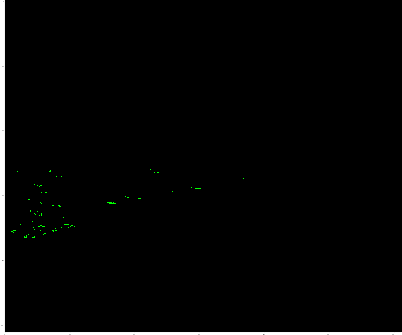

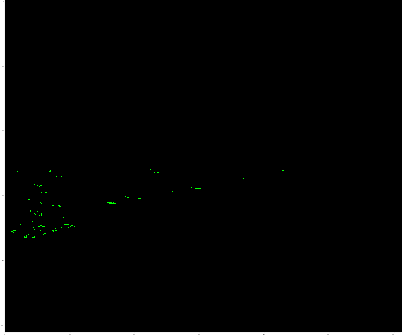

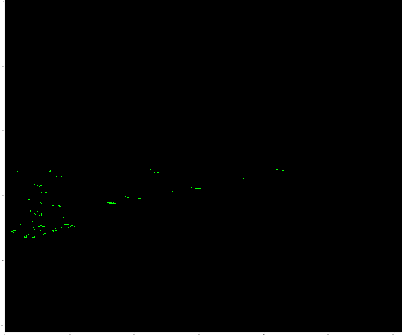

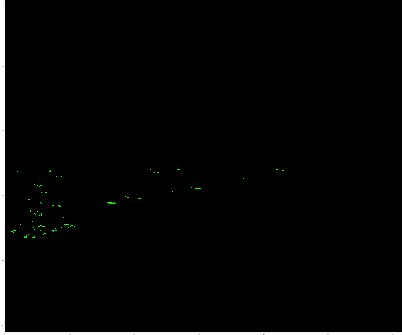

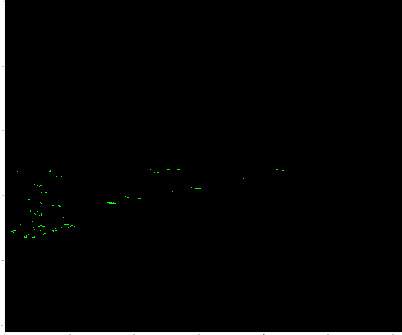

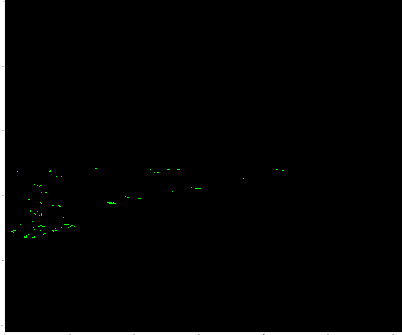

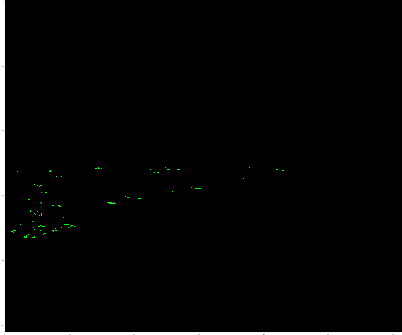

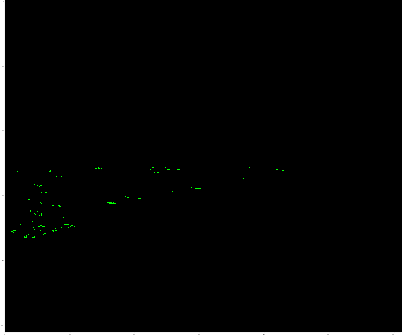

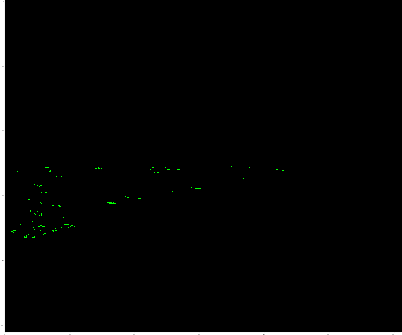

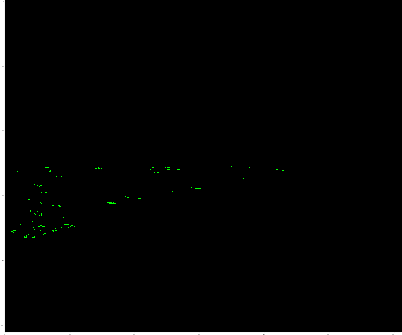

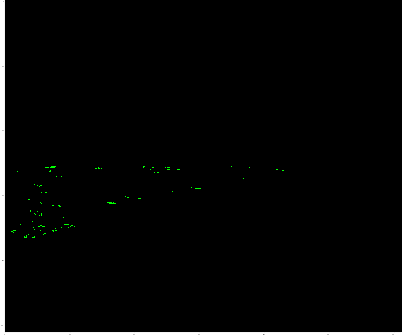

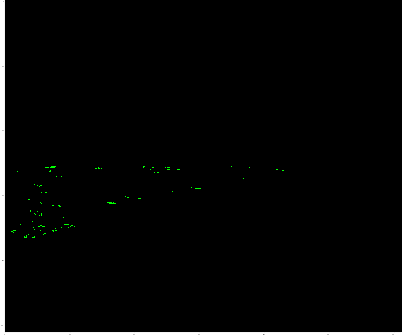

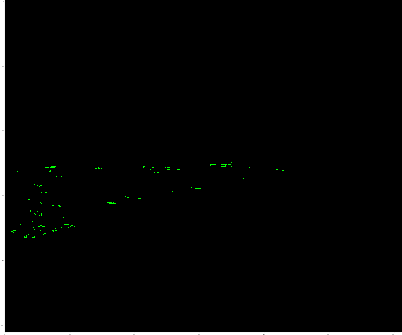

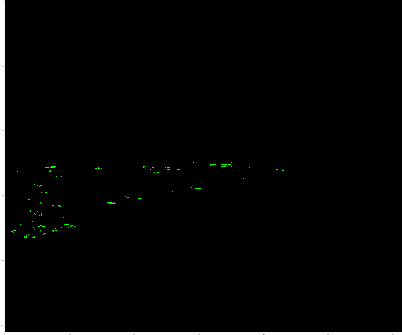

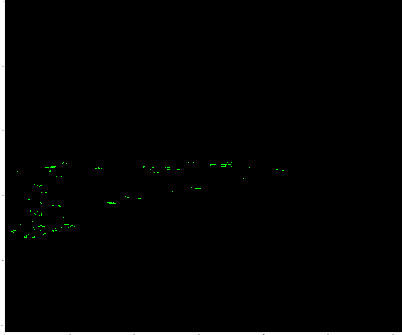

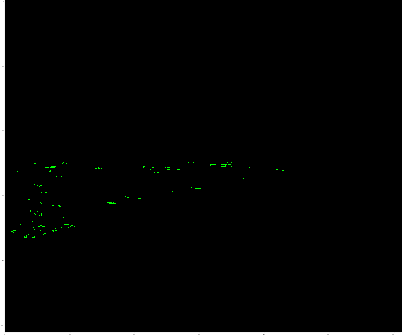

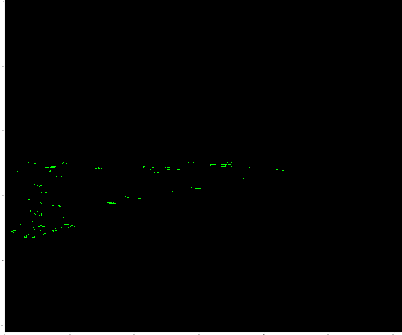

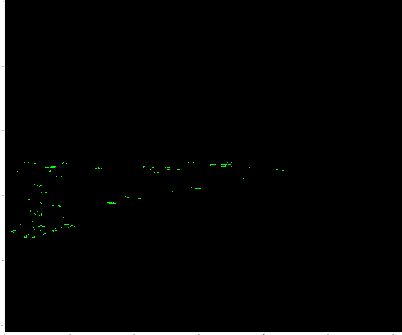

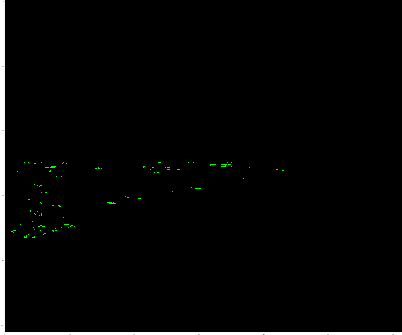

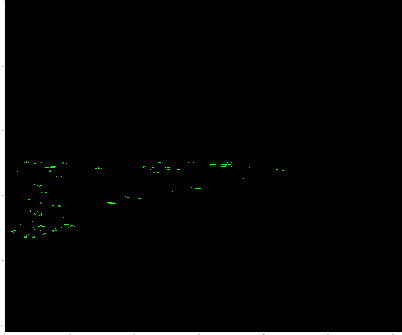

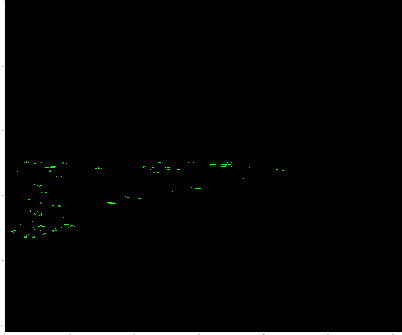

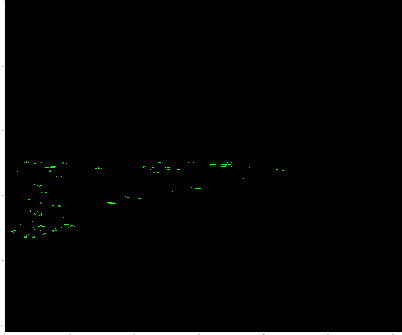

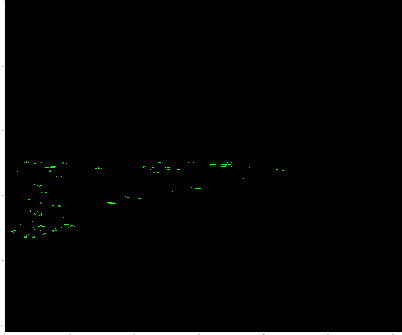

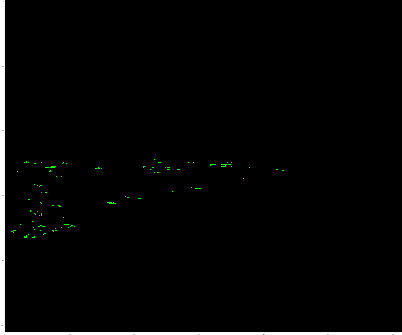

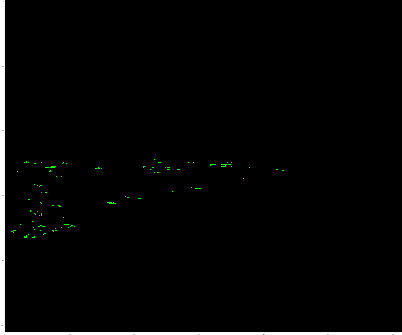

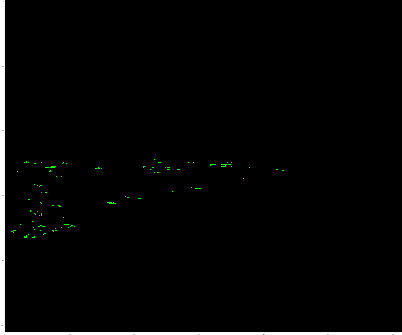

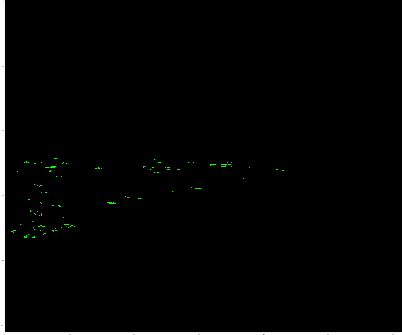

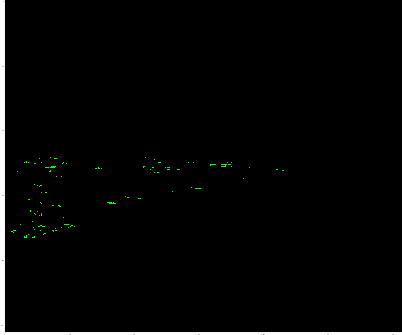

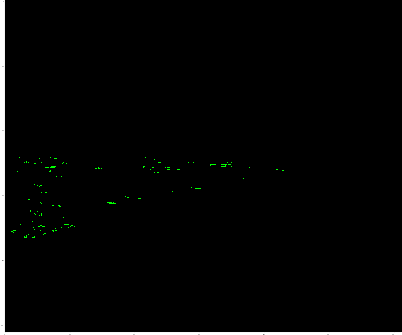

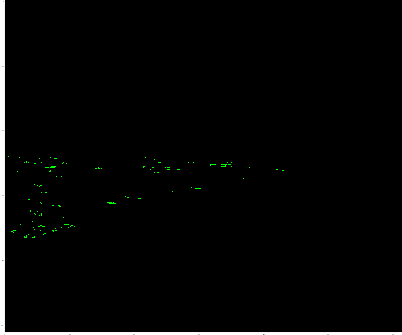

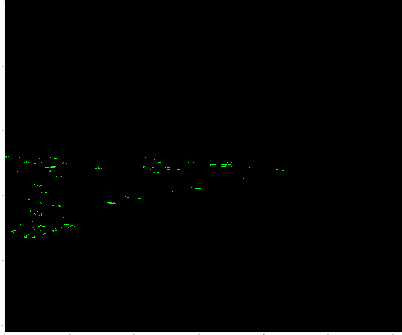

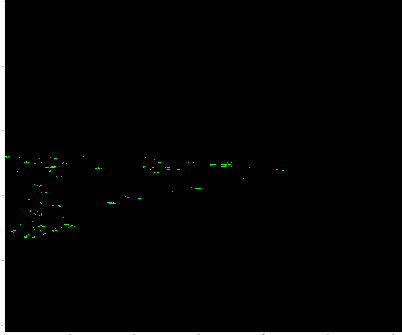

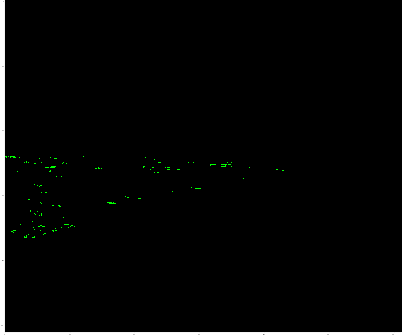

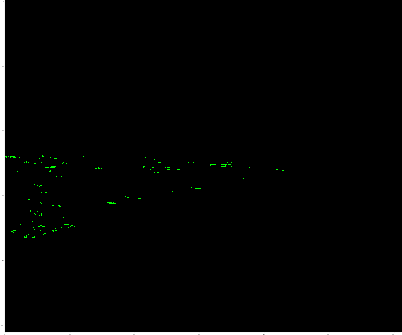

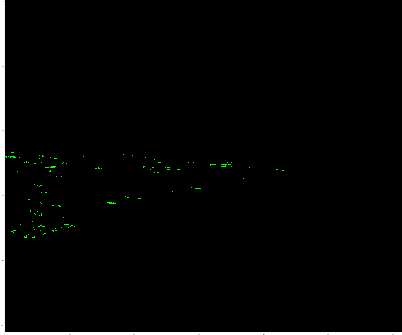

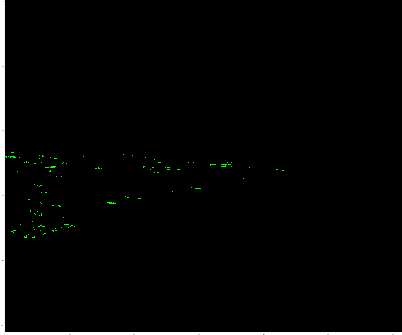

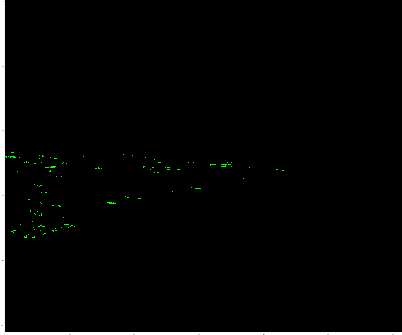

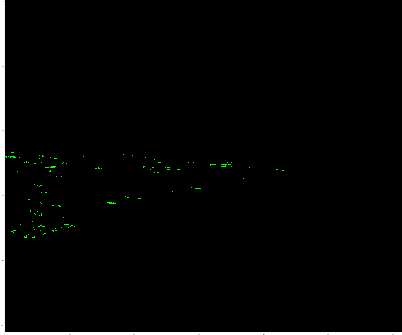

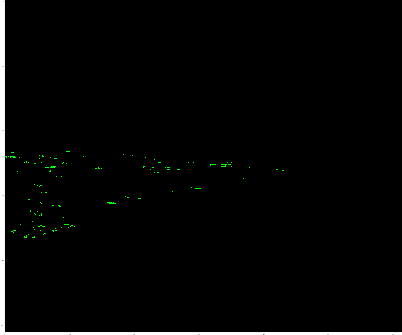

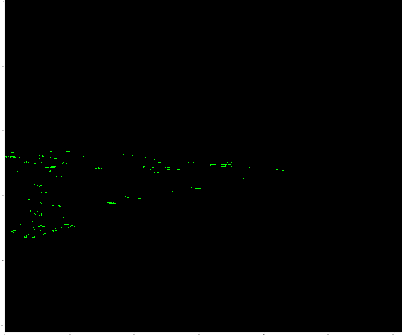

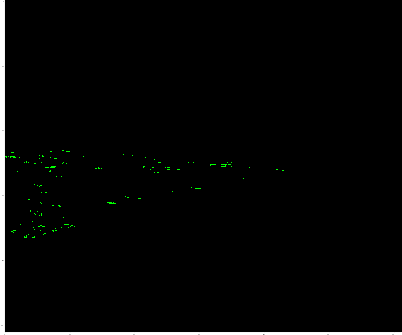

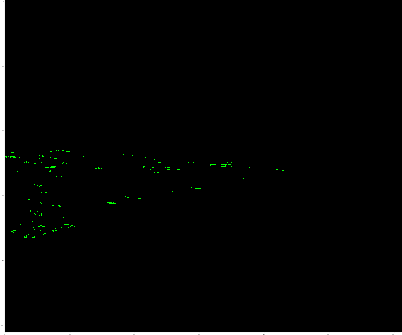

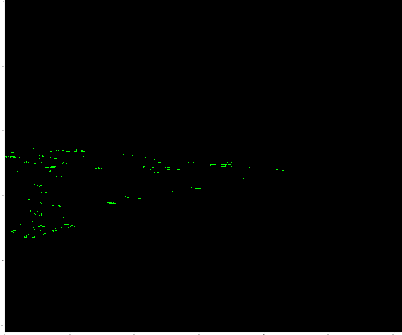

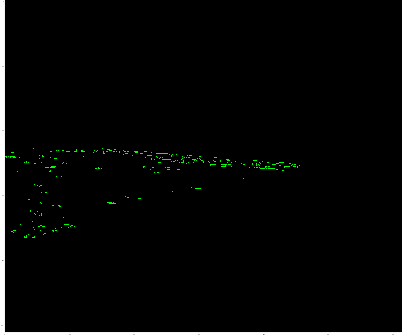

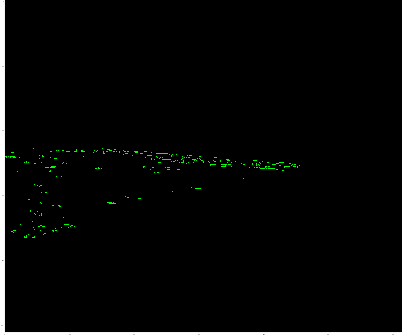

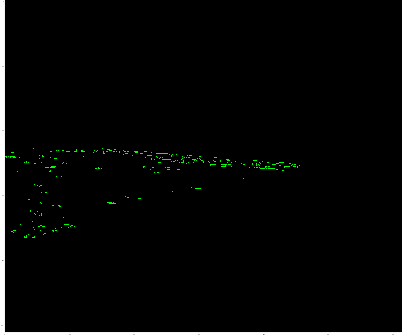

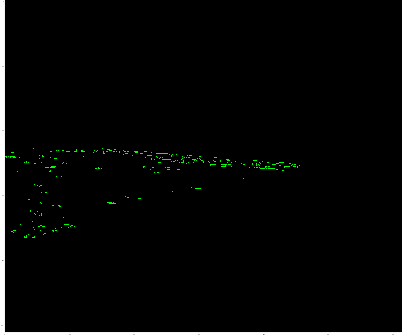

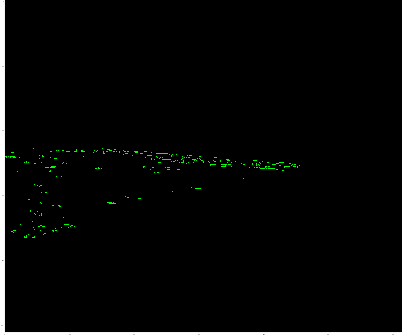

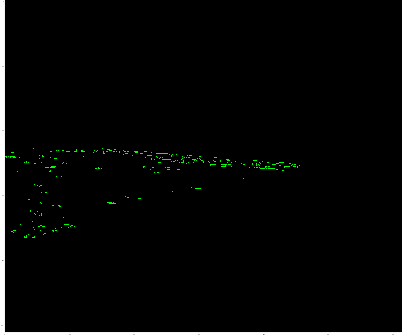

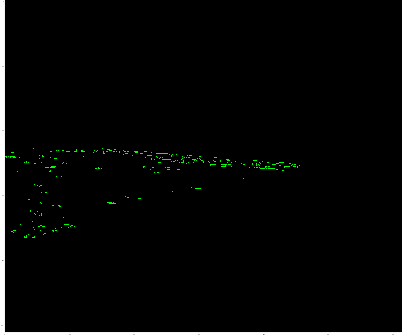

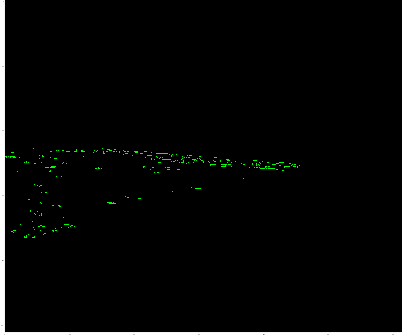

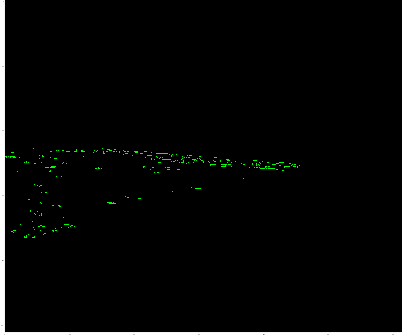

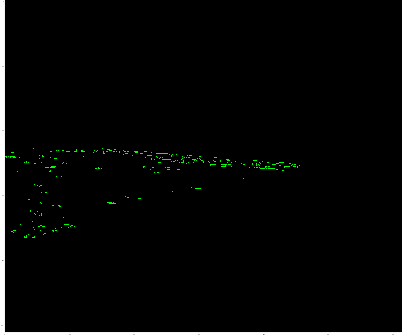

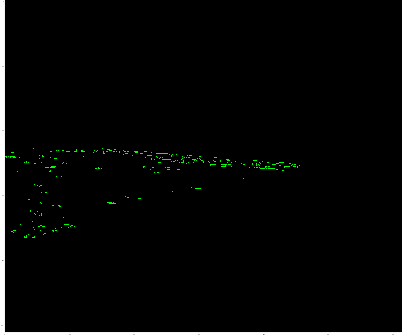

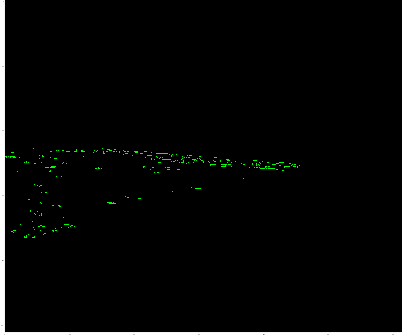

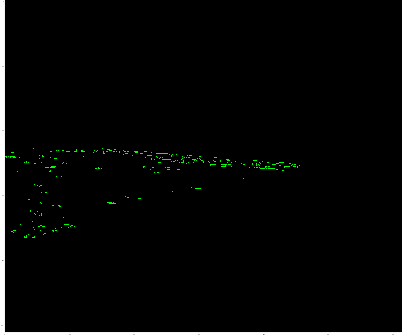

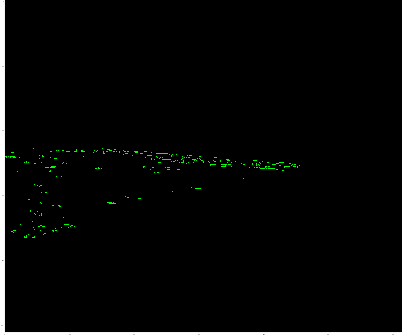

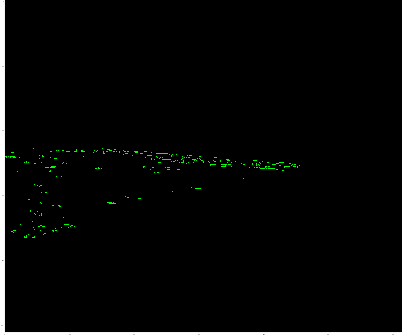

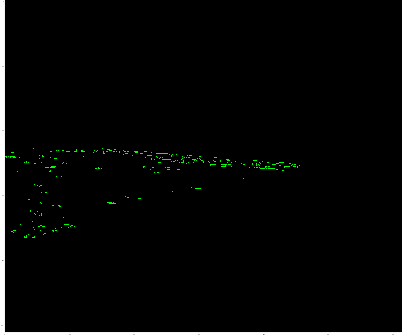

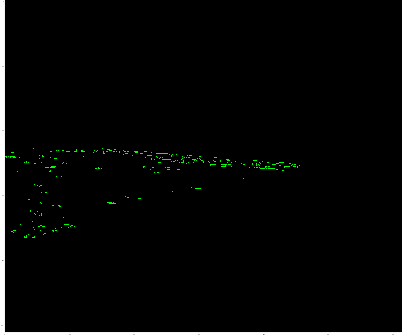

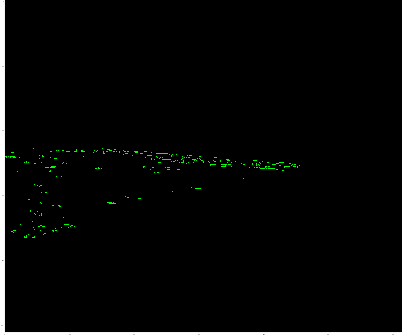

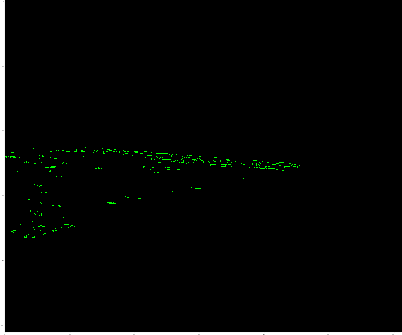

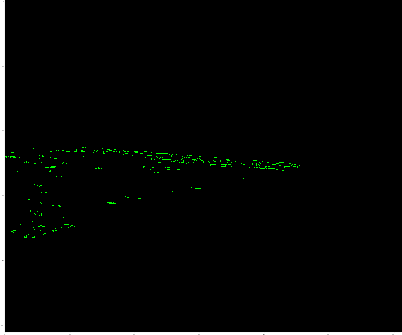

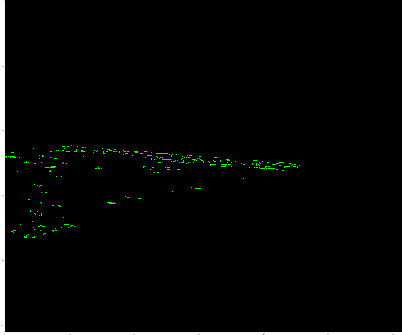

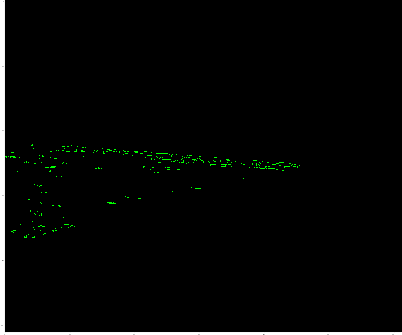

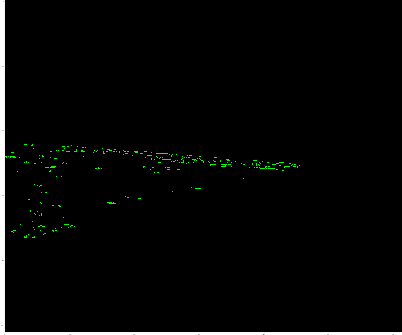

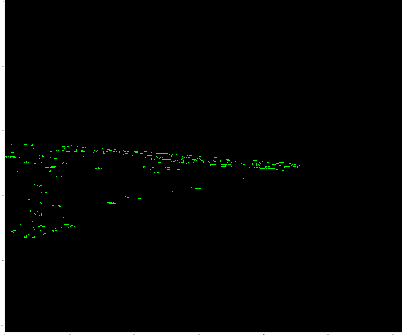

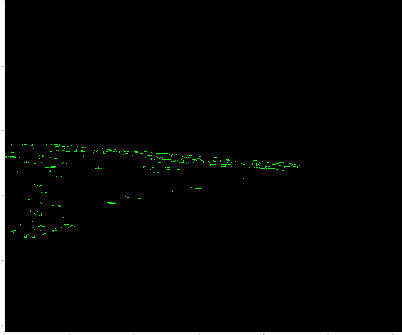

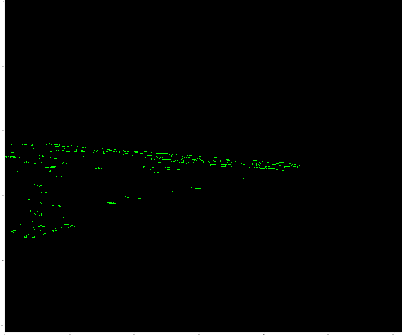

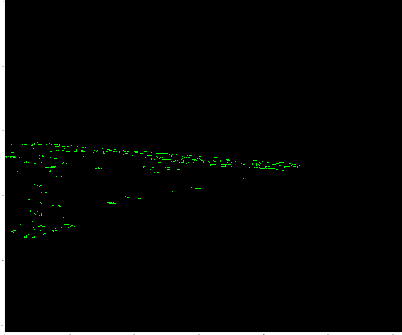

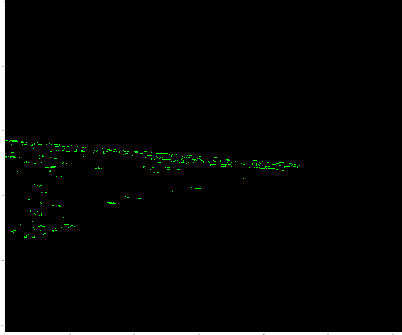

In [0]:
#rect
ret,thresh = cv2.threshold(bg_added,1,255,cv2.THRESH_BINARY)
imshow_colab(thresh, "gray")
thresh = f_to_uint(thresh)

# Finding contours for the thresholded image
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# create hull array for convex hull points
hull = []
 
# calculate points for each contour
for i in range(len(contours)):
    # creating convex hull object for each contour
    hull.append(cv2.convexHull(contours[i], False))

# create an empty black image
drawing = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8)
 
# draw contours and hull points
for i in range(len(contours)):
    color_contours = (0, 255, 0) # green - color for contours
    color = (255, 0, 0) # blue - color for convex hull
    # draw ith contour
    imshow_colab(cv2.drawContours(drawing, contours, i, color_contours, 1, 8, hierarchy))
    # draw ith convex hull object
    #imshow_colab(cv2.drawContours(drawing, hull, i, color, 1, 8))

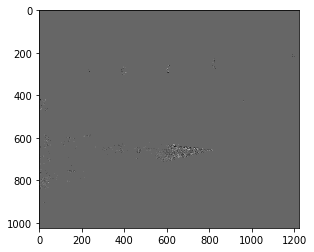

In [0]:
bg_added = np.fix(bg_added)
bg_added = bg_added.astype('uint8')
edges	=	cv2.Laplacian(bg_added, cv2.CV_32F)
fig = plt.figure()
plt.imshow(edges, cmap="gray",  vmin = 0, vmax = 1)
plt.show()

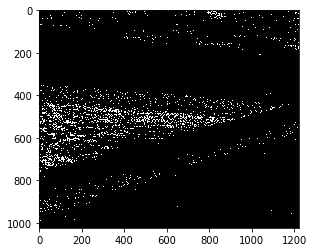

In [0]:
fgmask = np.fix(fgmask)
fgmask = fgmask.astype('uint8')
edges	=	cv2.Laplacian(fgmask, cv2.CV_32F)
fig = plt.figure()
plt.imshow(edges, cmap="gray",  vmin = 0, vmax = 1)
plt.show()

In [0]:
bg_added = np.fix(bg_added)
bg_added = bg_added.astype('uint8')
edges	=	cv2.Canny(bg_added, 30, 100)
fig = plt.figure()
plt.imshow(edges, cmap="gray")
plt.show()

0 1 [[  5  14  21 ...  40   1  81]
 [ 14  21  17 ...   1  79  84]
 [  7  18  21 ...  35  50  51]
 ...
 [ 88  89  81 ... 102  84 101]
 [ 72  81  72 ...  90  71  82]
 [ 88  84  83 ...  97  85  89]]


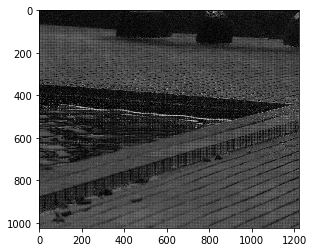

0 2 [[14 16 20 ... 20 25 58]
 [11 15 15 ...  1 58 42]
 [10 13 16 ... 37 60 26]
 ...
 [89 91 83 ... 97 85 99]
 [71 77 73 ... 88 70 85]
 [86 83 82 ... 92 83 91]]


0 3 [[ 9 17 12 ... 45 13 46]
 [ 9 19 19 ...  1 72 21]
 [15 16 10 ... 19 30 13]
 ...
 [84 92 83 ... 97 83 96]
 [73 80 73 ... 88 68 85]
 [79 83 85 ... 91 81 91]]


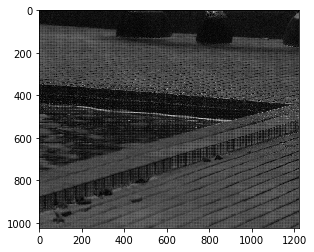

0 4 [[19 21 16 ... 23  7 40]
 [17 14 21 ...  1 36 69]
 [16 17  5 ... 45 15 32]
 ...
 [82 88 84 ... 97 83 93]
 [71 81 73 ... 88 69 82]
 [82 88 83 ... 92 80 93]]


0 5 [[19 15 18 ... 12  4 37]
 [15 14 22 ...  1 44 77]
 [11 15 12 ... 65 32 33]
 ...
 [83 85 82 ... 99 82 92]
 [64 81 73 ... 87 72 84]
 [80 84 80 ... 96 82 93]]


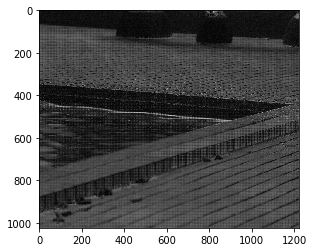

0 6 [[ 16  10  21 ...   6  27  44]
 [ 16  18  23 ...   1  44  80]
 [  6  11  13 ...  55  16  42]
 ...
 [ 83  81  83 ...  91  83  93]
 [ 66  82  63 ...  90  70  82]
 [ 78  82  79 ... 101  80  94]]


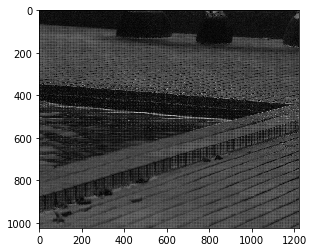

0 7 [[ 18   9  18 ...  25  14  64]
 [ 18  22  24 ...  43  44  82]
 [ 10  15  20 ...  28  33  38]
 ...
 [ 82  86  80 ...  88  82  91]
 [ 67  78  69 ...  90  69  85]
 [ 79  85  78 ... 103  83  96]]


0 8 [[12  9 18 ... 32  7 49]
 [17 26 13 ... 22 62 83]
 [12 15 14 ... 34 17 45]
 ...
 [81 89 80 ... 88 85 93]
 [67 77 66 ... 86 72 84]
 [82 86 78 ... 96 82 95]]


0 9 [[16 11 16 ... 33 28 39]
 [15 23 16 ... 11 31 42]
 [10 16  9 ... 37  9 48]
 ...
 [82 86 83 ... 94 83 93]
 [70 79 69 ... 87 72 86]
 [82 82 82 ... 95 80 91]]


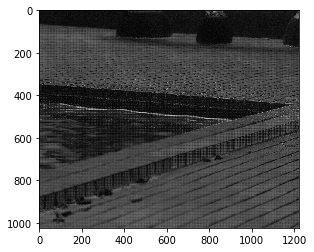

0 10 [[15  8 12 ... 36 14 37]
 [15 18 17 ...  6 38 21]
 [18 18 13 ... 19 30 49]
 ...
 [81 93 79 ... 97 82 91]
 [69 80 73 ... 88 70 88]
 [83 80 80 ... 96 83 88]]


0 11 [[17 16 16 ... 38  7 44]
 [12 14 22 ...  3 36 53]
 [15 21 16 ... 32 41 25]
 ...
 [87 87 81 ... 97 79 89]
 [71 81 67 ... 88 70 84]
 [81 89 80 ... 91 85 90]]


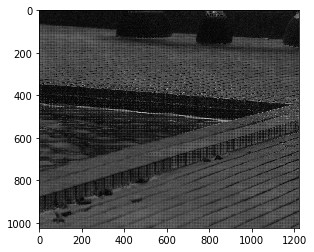

0 12 [[15 15 18 ... 19  4 48]
 [15 14 19 ...  2 40 27]
 [10 19 15 ... 16 45 30]
 ...
 [85 89 82 ... 99 83 93]
 [70 79 70 ... 89 76 85]
 [80 92 82 ... 89 88 94]]


0 13 [[18 14 19 ... 10  2 49]
 [14 14 19 ...  1 63 14]
 [15 16 12 ... 30 23 15]
 ...
 [85 89 82 ... 92 81 94]
 [72 81 68 ... 87 72 87]
 [79 90 81 ... 88 86 92]]


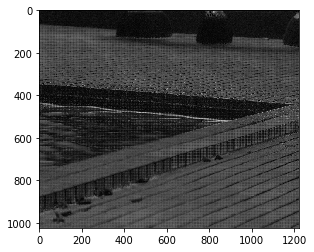

0 14 [[15 11 13 ... 27 27 25]
 [15 14 19 ...  1 50 49]
 [10 10 13 ... 37 36 25]
 ...
 [85 79 82 ... 92 82 89]
 [72 83 73 ... 86 68 88]
 [80 89 82 ... 87 84 93]]


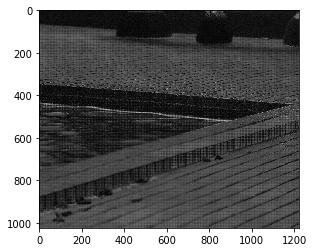

0 15 [[13 12 16 ... 14 49 30]
 [11 14 23 ...  1 51 66]
 [ 7 19 10 ... 54 18 35]
 ...
 [83 85 82 ... 94 83 88]
 [72 83 73 ... 87 70 89]
 [81 85 80 ... 96 83 95]]


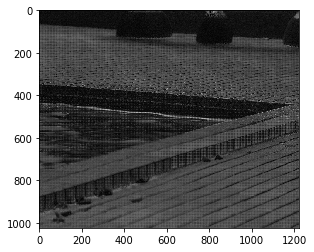

0 16 [[ 16  10  18 ...  24  49  57]
 [ 11  14  14 ...   1  43  75]
 [  9  16  11 ...  53   9  43]
 ...
 [ 85  86  88 ...  94  84  88]
 [ 69  82  74 ...  88  69  86]
 [ 80  84  82 ... 100  82  91]]


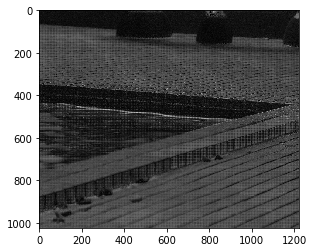

0 17 [[15 12 19 ... 32 60 46]
 [15 19 18 ...  1 22 38]
 [11 15  9 ... 46  5 44]
 ...
 [86 87 89 ... 94 83 89]
 [70 79 72 ... 88 70 84]
 [80 86 79 ... 98 83 92]]


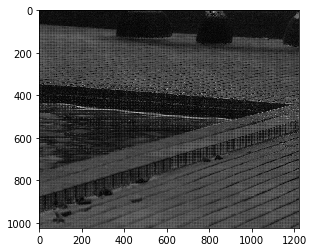

0 18 [[20 10 13 ... 51 55 48]
 [14 27 19 ... 42 11 19]
 [19 14 14 ... 40  3 40]
 ...
 [86 90 85 ... 92 82 93]
 [67 78 69 ... 85 72 87]
 [82 89 81 ... 96 84 93]]


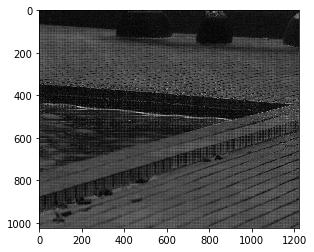

0 19 [[20 16 13 ... 46 52 67]
 [ 9 18 18 ... 21 53 10]
 [12 11 17 ... 20 27 37]
 ...
 [87 83 85 ... 89 83 91]
 [70 75 69 ... 80 71 83]
 [78 85 84 ... 93 89 96]]


0 20 [[20 14 16 ... 43 26 59]
 [13 26 19 ... 11 44  5]
 [13 14 15 ... 30 38 36]
 ...
 [86 88 84 ... 88 82 90]
 [66 77 72 ... 84 70 84]
 [75 82 84 ... 97 88 95]]


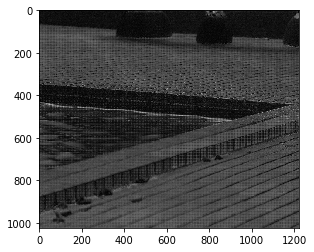

0 21 [[16 11 14 ... 44 13 47]
 [13 20 19 ...  6 22  3]
 [13 11 20 ... 35 19 18]
 ...
 [84 89 87 ... 95 80 89]
 [68 84 71 ... 86 72 85]
 [76 85 83 ... 94 87 91]]


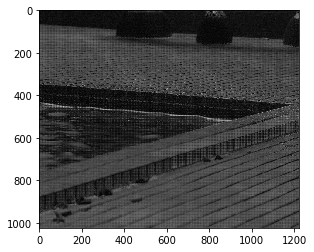

0 22 [[18 10 14 ... 42  7 24]
 [13 20 20 ...  3 28  2]
 [10 14 14 ... 18 45 26]
 ...
 [82 85 84 ... 91 76 93]
 [69 82 72 ... 85 71 84]
 [76 86 86 ... 93 83 91]]


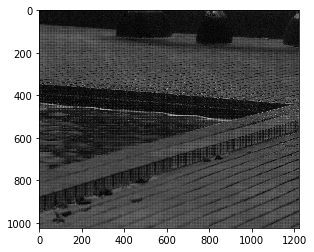

0 23 [[16 15 11 ... 43 29 52]
 [11 15 19 ...  2 54  1]
 [12 11 14 ... 27 23 39]
 ...
 [82 83 83 ... 90 80 99]
 [69 83 68 ... 85 71 82]
 [85 86 83 ... 91 85 97]]


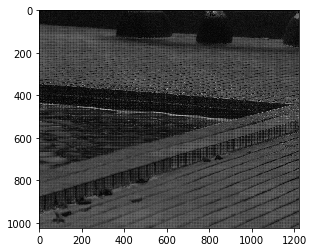

0 24 [[15 14  8 ... 44 39 26]
 [ 7 15 21 ...  1 53 42]
 [12 18 13 ... 33 12 45]
 ...
 [85 87 81 ... 92 82 99]
 [72 80 73 ... 82 71 84]
 [86 83 84 ... 89 85 98]]


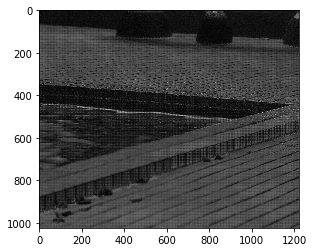

0 25 [[ 8 14  9 ... 22 81 31]
 [11 14 17 ...  1 68 52]
 [12 13 21 ... 52 31 40]
 ...
 [88 90 82 ... 97 83 98]
 [74 83 73 ... 84 71 80]
 [86 84 82 ... 89 84 96]]


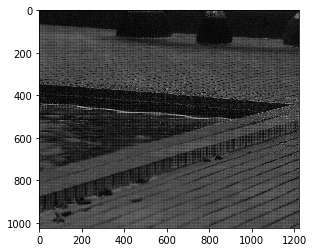

0 26 [[13 16 19 ... 33 65 41]
 [17 12 20 ...  1 34 68]
 [12 18 13 ... 48 40 20]
 ...
 [87 88 84 ... 92 84 98]
 [73 82 72 ... 85 70 83]
 [85 82 85 ... 89 85 95]]


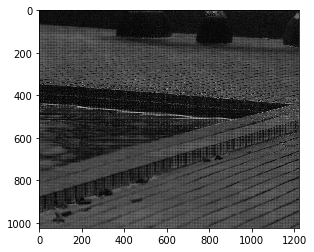

0 27 [[10 17 16 ... 52 68 38]
 [18 14 21 ...  1 35 76]
 [12 13 10 ... 46 55 50]
 ...
 [87 94 82 ... 88 87 97]
 [75 80 73 ... 83 71 82]
 [80 82 87 ... 93 83 95]]


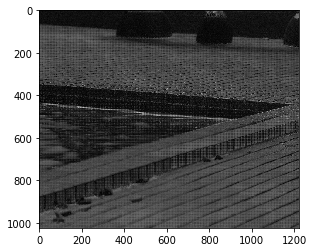

0 28 [[ 7 15 19 ... 26 34 59]
 [17 17 20 ...  1 18 97]
 [12 16 15 ... 58 28 65]
 ...
 [88 93 81 ... 94 85 95]
 [76 81 71 ... 84 71 82]
 [81 88 85 ... 97 85 92]]


KeyboardInterrupt: ignored

In [0]:
#　多分いらない
image_added = image_frames[0].copy()
i=0
for img in image_frames[:FRAMES]:
  i += 1
  image_added = cv2.addWeighted(image_added, 0.5, img, 0.5, 0)
  #print(0, i, image_added)
  image_added_fig = np.fix(image_added)
  image_added_fig = image_added_fig.astype('uint8')
  print(0, i, image_added_fig)
  fig = plt.figure()
  plt.imshow(image_added_fig, cmap="gray", vmin = 0, vmax = 255)
  plt.show()

i=0
image_added = image_frames[FRAMES].copy()
for img in image_frames[FRAMES:]:
  i += 1
  image_added = cv2.addWeighted(image_added, 0.5, img, 0.5, 0)  
  #print(1, i, image_added)
  image_added_fig = np.fix(image_added)
  image_added_fig = image_added_fig.astype('uint8')
  #print(0, i, image_added_fig)
  fig = plt.figure()
  plt.imshow(image_added_fig, cmap="gray",  vmin = 0, vmax = 255)
  plt.show()


#image_added = image_added // FRAMES
#image_added.astype('uint8')
#print(image_added.shape)
#image_added =  np.clip(image_added, 0, 255)



0
bg_added


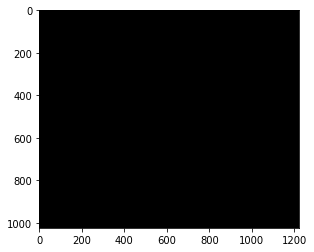

1
bg_added


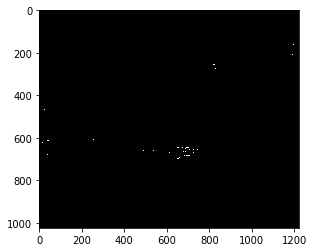

2
bg_added


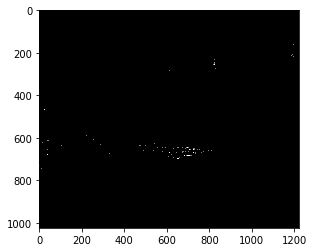

3
bg_added


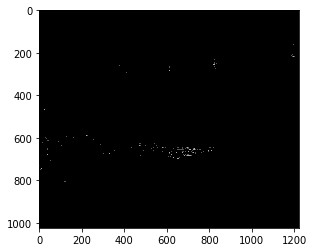

4
bg_added


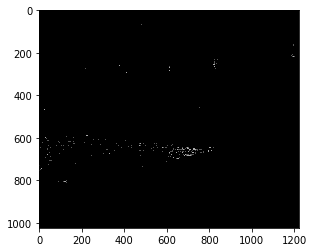

5
bg_added


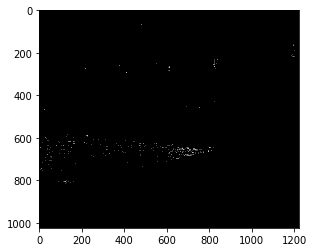

6
bg_added


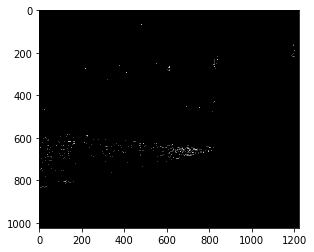

7
bg_added


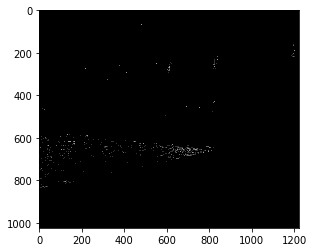

8
bg_added


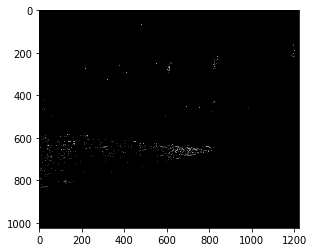

9
bg_added


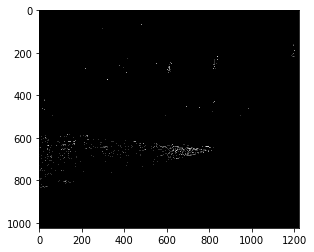

10
bg_added


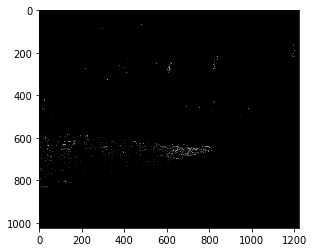

11
bg_added


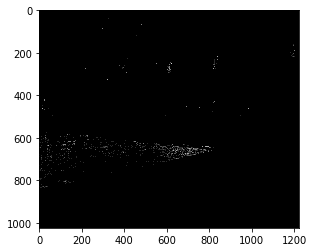

12
bg_added


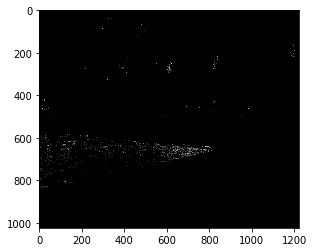

13
bg_added


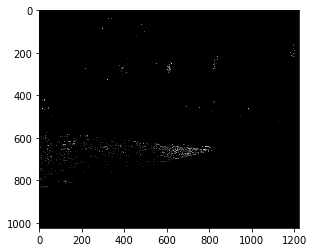

14
bg_added


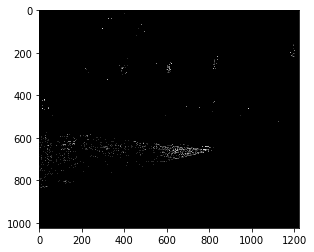

15
bg_added


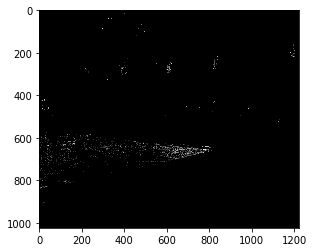

16
bg_added


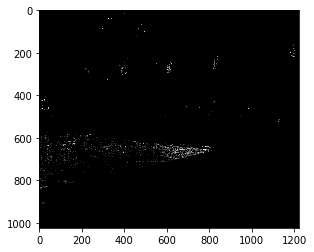

17
bg_added


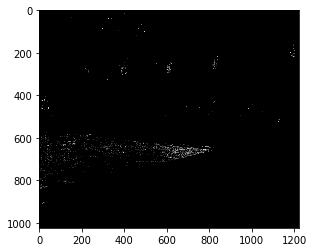

18
bg_added


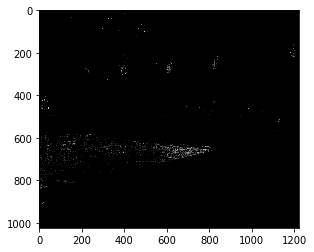

19
bg_added


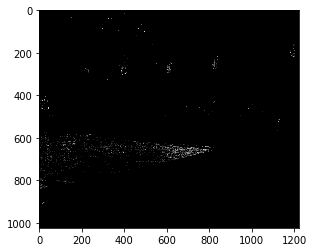

20
bg_added


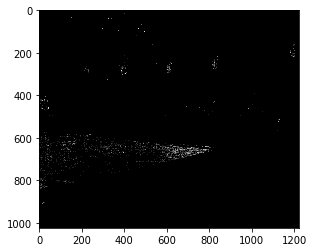

21
bg_added


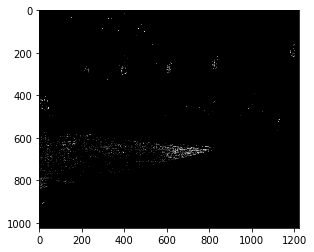

22
bg_added


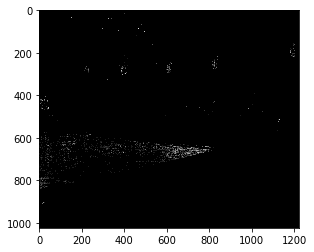

23
bg_added


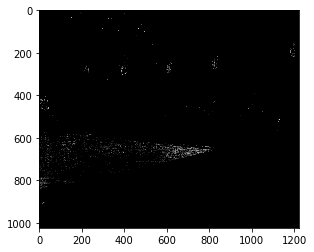

24
bg_added


25
bg_added


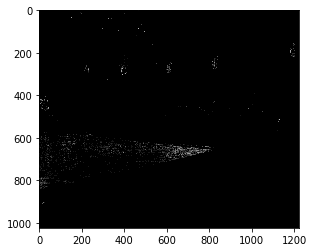

26
bg_added


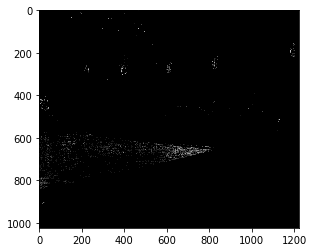

27
bg_added


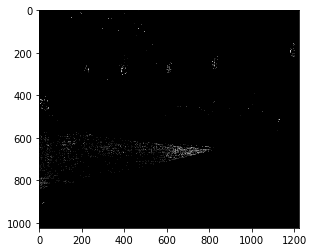

28
bg_added


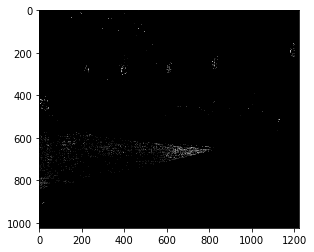

29
bg_added


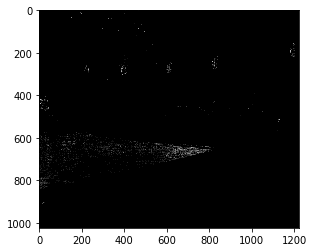

30
bg_added


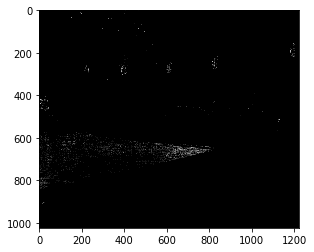

31
bg_added


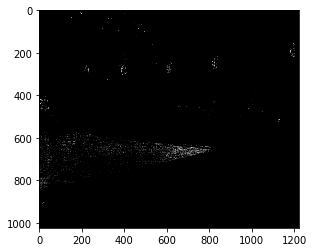

32
bg_added


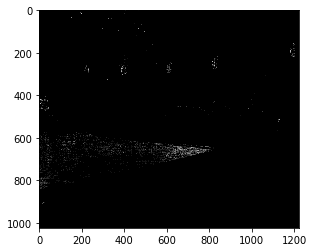

33
bg_added


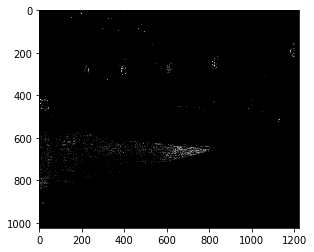

34
bg_added


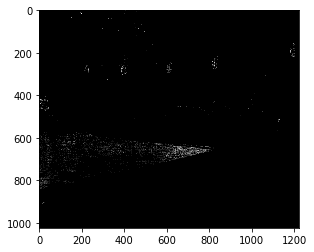

35
bg_added


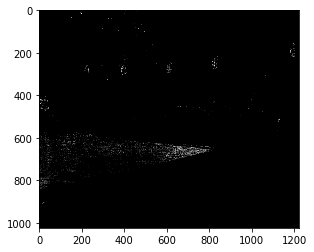

36
bg_added


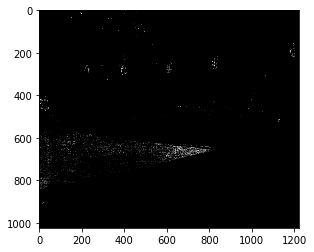

37
bg_added


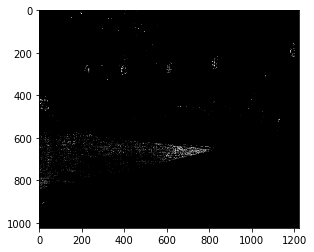

38
bg_added


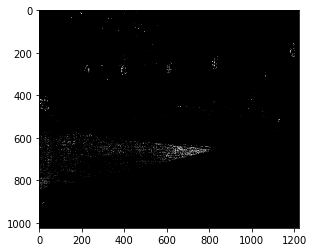

39
bg_added


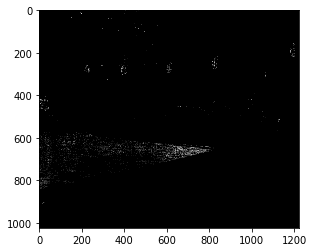

40
bg_added


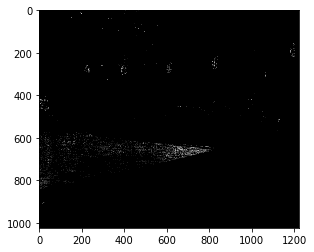

41
bg_added


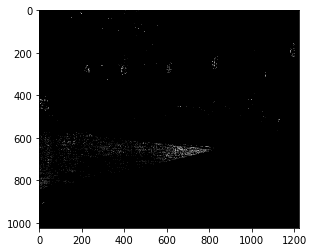

42
bg_added


43
bg_added


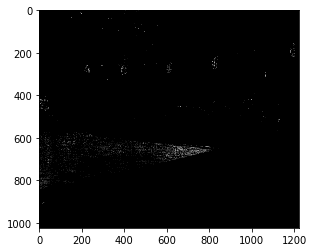

44
bg_added


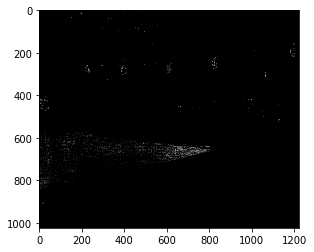

45
bg_added


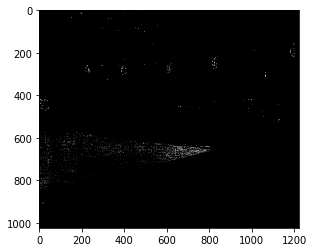

46
bg_added


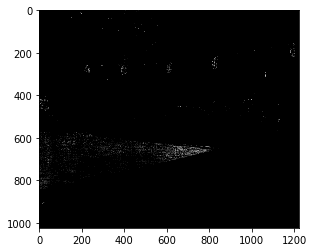

47
bg_added


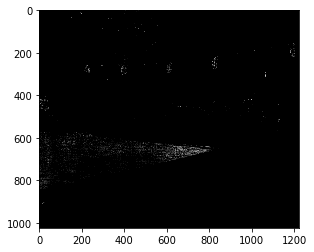

48
bg_added


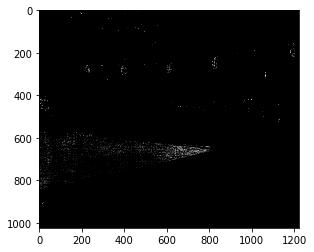

49
bg_added


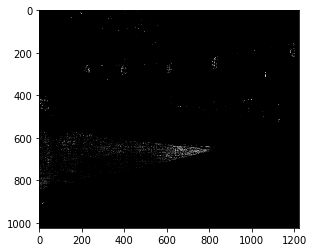

In [0]:
# ファイル名
#=======================================
originalInputFileName     = "50mm_rho.avi" # <-- ここを自分で用意した画像に変えること
#=======================================
originalInputFileBaseName, originalInputFileExt = os.path.splitext(originalInputFileName)

# 画像のフルパスの設定（要 os パッケージ）
originalInputFilePath = os.path.join(dataDir, originalInputFileName)
cap = cv2.VideoCapture(originalInputFilePath)
ret, frame = cap.read()
row, col, _ = frame.shape
bg_added = np.zeros((row, col))
#fgbg = cv2.createBackgroundSubtractorMOG2(varThreshold = 25, detectShadows=False)
fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()
i = 0
loops = 50
for i in range(loops):
    ret, frame = cap.read()

    fgmask = fgbg.apply(frame)
    bg_added += fgmask
    print(i)
    print("bg_added")
    fig = plt.figure()
    plt.imshow(bg_added, cmap="gray")
    plt.show()

bg_added = bg_added // loops
cap.release()